# Flair NLP Framework

In [ ]:
!pip install --upgrade flair==0.11.1
!pip install torch
!pip install importlib-metadata
!pip install emoji
!pip install nltk
!pip install sacremoses


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 5.2 MB/s 
     |████████████████████████████████| 48 kB 6.4 MB/s 
     |████████████████████████████████| 788 kB 64.7 MB/s 
     |████████████████████████████████| 46 kB 4.5 MB/s 
     |████████████████████████████████| 1.6 MB 52.4 MB/s 
     |████████████████████████████████| 1.2 MB 36.1 MB/s 
     |████████████████████████████████| 4.2 MB 35.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 981 kB 39.9 MB/s 
     |████████████████████████████████| 19.7 MB 93.0 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 199 kB 72.5 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |█████████████████████████

In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time
import joblib
from flair.data import Corpus, Sentence
from flair.datasets import ClassificationCorpus, CSVClassificationCorpus, TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings, TransformerDocumentEmbeddings, StackedEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.visual.training_curves import Plotter
from flair.hyperparameter.param_selection import SearchSpace, Parameter
from flair.hyperparameter.param_selection import TextClassifierParamSelector, OptimizationValue
from hyperopt import hp
from pathlib import Path
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from typing import List

from google.colab import drive
drive.mount('/content/drive')

import torch
from torch.optim.adam import Adam
torch.cuda.is_available()


Mounted at /content/drive


True

# Paths

In [ ]:
# Parent paths
google_path = '/content/drive/My Drive/'
local_path = '/home/v.zevallosm/'
parent_path = google_path

#Specific paths
path_corpus = parent_path+"team project/data set/dataset search/twitter_and_cyberbullying/data.csv"  

path_flair = parent_path+"team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/"
path_flair_train = path_flair+"train.csv"
path_flair_dev = path_flair+"dev.csv"
path_flair_test = path_flair+"test.csv"


path_model_hyperparameters_distilbert = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_hyperparameters_distilbert"
path_model_hyperparameters_distilbert_mb3 = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_hyperparameters_distilbert_mb3"
path_model_hyperparameters_distilbert_mb4 = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_hyperparameters_distilbert_mb4"
path_model_hyperparameters_distilbert_mb5 = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_hyperparameters_distilbert_mb5"


# Data Exploration

,tweet,label
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


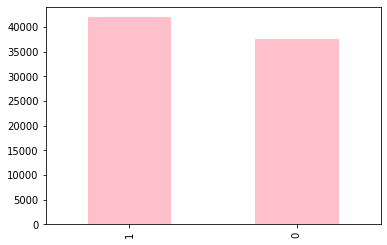

In [ ]:
data = pd.read_csv(path_corpus)

data['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))
data.head()

# Fast text format and split Dataset

In [ ]:
data['label'] = '__label__' + data['label'].astype(str)

train, test = train_test_split(data, test_size=0.2, random_state = 453, stratify=data['label'])
test, dev = train_test_split(test, test_size=0.5 , random_state = 453, stratify= test['label'])

train.to_csv(path_flair_train, sep='\t', index = False, header = False)
test.to_csv(path_flair_test, sep='\t', index = False, header = False)
dev.to_csv(path_flair_dev, sep='\t', index = False, header = False)

train.head(5)

,tweet,label
21782,@DianH4 @ExposeFalsehood .....80% of Afghan ci...,__label__1
28378,Having a high level of toxicity in your commun...,__label__1
33213,I started school in Darwin 1971...Cheesy warm ...,__label__1
59425,this is what #waiting at 2:30am for the shuttl...,__label__0
52405,home sweet second home... #vegas #girltime #d...,__label__0


# Hyperparameter tunning

## Distilbert

In [ ]:
column_name_map = {0: "text", 1: "label_topic"}
corpus: Corpus = CSVClassificationCorpus(path_flair,
                                         column_name_map,
                                         skip_header=True,
                                         delimiter='\t',   # tab-separated files
                                         label_type= "label")
print(corpus)

2022-05-29 19:38:26,281 Reading data from /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape
2022-05-29 19:38:26,282 Train: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/train.csv
2022-05-29 19:38:26,285 Dev: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/dev.csv
2022-05-29 19:38:26,290 Test: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/test.csv
Corpus: 63722 train + 7965 dev + 7964 test sentences


In [ ]:
# Part 1 Mini Batch size 3
search_space = SearchSpace()

# define training hyperparameters
search_space.add(Parameter.LEARNING_RATE, hp.choice, options=[5.0e-5, 5.0e-4, 0.0005, 0.005])
search_space.add(Parameter.MINI_BATCH_SIZE, hp.choice, options=[3])

# define transformer embedding hyperparameters
search_space.add(Parameter.TRANSFORMER_MODEL, hp.choice, options=['distilbert-base-uncased'])

# what label do we want to predict?
label_type = 'label'

# create the parameter selector
param_selector = TextClassifierParamSelector(
    corpus,
    label_type, 
    False, 
    path_model_hyperparameters_distilbert_mb3, 
    max_epochs=3, 
    fine_tune=True,
    training_runs=1,
    optimization_value=OptimizationValue.DEV_LOSS
)

# start the optimization
param_selector.optimize(search_space, max_evals=8)

2022-05-21 13:09:22,519 Computing label dictionary. Progress:


63722it [00:40, 1561.74it/s]

2022-05-21 13:10:03,338 Dictionary created for label 'label' with 3 values: __label__1 (seen 33590 times), __label__0 (seen 30132 times)
  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]2022-05-21 13:10:03,349 ----------------------------------------------------------------------------------------------------
2022-05-21 13:10:03,350 Evaluation run: 1
2022-05-21 13:10:03,354 Evaluating parameter combination:
2022-05-21 13:10:03,358 	learning_rate: 0.0005
2022-05-21 13:10:03,360 	mini_batch_size: 3
2022-05-21 13:10:03,363 	model: distilbert-base-uncased
2022-05-21 13:10:03,367 ----------------------------------------------------------------------------------------------------
2022-05-21 13:10:03,370 ----------------------------------------------------------------------------------------------------
2022-05-21 13:10:03,373 Training run: 1


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

2022-05-21 13:11:13,787 ----------------------------------------------------------------------------------------------------
2022-05-21 13:11:13,794 Model: "TextClassifier(
  (decoder): Linear(in_features=768, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_featur

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 5/2655 [00:00<00:59, 44.40it/s]

  0%|          | 10/2655 [00:00<00:59, 44.62it/s]

  1%|          | 15/2655 [00:00<01:01, 42.97it/s]

  1%|          | 21/2655 [00:00<00:56, 46.49it/s]

  1%|          | 26/2655 [00:00<00:59, 44.25it/s]

  1%|1         | 31/2655 [00:00<00:58, 45.22it/s]

  1%|1         | 36/2655 [00:00<00:57, 45.50it/s]

  2%|1         | 41/2655 [00:00<01:00, 43.29it/s]

  2%|1         | 46/2655 [00:01<01:00, 42.81it/s]

  2%|1         | 51/2655 [00:01<00:58, 44.75it/s]

  2%|2         | 56/2655 [00:01<00:58, 44.35it/s]

  2%|2         | 61/2655 [00:01<00:57, 44.79it/s]

  2%|2         | 66/2655 [00:01<00:58, 44.56it/s]

  3%|2         | 71/2655 [00:01<00:56, 45.63it/s]

  3%|2         | 76/2655 [00:01<00:55, 46.20it/s]

  3%|3         | 81/2655 [00:01<00:58, 44.09it/s]

  3%|3         | 87/2655 [00:01<00:55, 46.49it/s]

  3%|3         | 92/2655 [00:02<00:54, 47.23it/s]

  4%|3         | 98/2655 [00:02<00:52, 48

2022-05-21 13:34:55,256 Evaluating as a multi-label problem: False
2022-05-21 13:34:55,330 DEV : loss 0.11204670369625092 - f1-score (micro avg)  0.8842
2022-05-21 13:35:01,019 BAD EPOCHS (no improvement): 0
2022-05-21 13:35:01,029 ----------------------------------------------------------------------------------------------------
2022-05-21 13:37:16,849 epoch 2 - iter 2124/21241 - loss 0.10926866 - samples/sec: 48.28 - lr: 0.000500
2022-05-21 13:39:32,864 epoch 2 - iter 4248/21241 - loss 0.11035330 - samples/sec: 48.43 - lr: 0.000500
2022-05-21 13:41:48,359 epoch 2 - iter 6372/21241 - loss 0.10921742 - samples/sec: 48.35 - lr: 0.000500
2022-05-21 13:44:03,819 epoch 2 - iter 8496/21241 - loss 0.10888409 - samples/sec: 48.37 - lr: 0.000500
2022-05-21 13:46:19,568 epoch 2 - iter 10620/21241 - loss 0.10753051 - samples/sec: 48.25 - lr: 0.000500
2022-05-21 13:48:35,126 epoch 2 - iter 12744/21241 - loss 0.10664996 - samples/sec: 48.31 - lr: 0.000500
2022-05-21 13:50:49,547 epoch 2 - iter 14

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 5/2655 [00:00<01:00, 43.47it/s]

  0%|          | 10/2655 [00:00<00:57, 45.74it/s]

  1%|          | 15/2655 [00:00<01:00, 43.42it/s]

  1%|          | 20/2655 [00:00<00:58, 44.79it/s]

  1%|          | 25/2655 [00:00<00:58, 45.14it/s]

  1%|1         | 30/2655 [00:00<00:57, 45.64it/s]

  1%|1         | 35/2655 [00:00<00:56, 46.72it/s]

  2%|1         | 40/2655 [00:00<00:59, 43.94it/s]

  2%|1         | 45/2655 [00:01<00:59, 43.85it/s]

  2%|1         | 50/2655 [00:01<00:58, 44.42it/s]

  2%|2         | 55/2655 [00:01<00:59, 43.58it/s]

  2%|2         | 60/2655 [00:01<00:58, 44.58it/s]

  2%|2         | 65/2655 [00:01<00:56, 45.58it/s]

  3%|2         | 70/2655 [00:01<00:55, 46.37it/s]

  3%|2         | 75/2655 [00:01<00:55, 46.59it/s]

  3%|3         | 80/2655 [00:01<00:56, 45.89it/s]

  3%|3         | 85/2655 [00:01<00:55, 46.53it/s]

  3%|3         | 90/2655 [00:01<00:54, 47.13it/s]

  4%|3         | 96/2655 [00:02<00:50, 50

2022-05-21 13:58:33,331 Evaluating as a multi-label problem: False
2022-05-21 13:58:33,393 DEV : loss 0.10024278610944748 - f1-score (micro avg)  0.8947
2022-05-21 13:58:39,034 BAD EPOCHS (no improvement): 0
2022-05-21 13:58:39,044 ----------------------------------------------------------------------------------------------------
2022-05-21 14:00:54,348 epoch 3 - iter 2124/21241 - loss 0.09960982 - samples/sec: 48.45 - lr: 0.000500
2022-05-21 14:03:09,963 epoch 3 - iter 4248/21241 - loss 0.09779754 - samples/sec: 48.55 - lr: 0.000500
2022-05-21 14:05:24,454 epoch 3 - iter 6372/21241 - loss 0.09890023 - samples/sec: 48.70 - lr: 0.000500
2022-05-21 14:07:39,878 epoch 3 - iter 8496/21241 - loss 0.10029708 - samples/sec: 48.41 - lr: 0.000500
2022-05-21 14:09:56,359 epoch 3 - iter 10620/21241 - loss 0.09973215 - samples/sec: 48.04 - lr: 0.000500
2022-05-21 14:12:11,343 epoch 3 - iter 12744/21241 - loss 0.09916611 - samples/sec: 48.54 - lr: 0.000500
2022-05-21 14:14:26,320 epoch 3 - iter 14

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 5/2655 [00:00<01:00, 43.65it/s]

  0%|          | 10/2655 [00:00<00:57, 45.60it/s]

  1%|          | 15/2655 [00:00<01:01, 42.64it/s]

  1%|          | 20/2655 [00:00<00:59, 44.56it/s]

  1%|          | 25/2655 [00:00<00:58, 44.78it/s]

  1%|1         | 30/2655 [00:00<00:58, 45.18it/s]

  1%|1         | 35/2655 [00:00<00:57, 45.36it/s]

  2%|1         | 40/2655 [00:00<01:00, 42.87it/s]

  2%|1         | 45/2655 [00:01<01:00, 43.38it/s]

  2%|1         | 50/2655 [00:01<00:58, 44.36it/s]

  2%|2         | 55/2655 [00:01<00:59, 43.53it/s]

  2%|2         | 60/2655 [00:01<00:58, 44.42it/s]

  2%|2         | 65/2655 [00:01<00:57, 45.10it/s]

  3%|2         | 70/2655 [00:01<00:56, 45.68it/s]

  3%|2         | 75/2655 [00:01<00:56, 45.79it/s]

  3%|3         | 80/2655 [00:01<00:57, 44.95it/s]

  3%|3         | 85/2655 [00:01<00:56, 45.63it/s]

  3%|3         | 90/2655 [00:02<00:55, 46.29it/s]

  4%|3         | 96/2655 [00:02<00:51, 49

2022-05-21 14:22:11,163 Evaluating as a multi-label problem: False
2022-05-21 14:22:11,229 DEV : loss 0.10641242563724518 - f1-score (micro avg)  0.8986
2022-05-21 14:22:16,923 BAD EPOCHS (no improvement): 0
2022-05-21 14:22:16,934 ----------------------------------------------------------------------------------------------------
2022-05-21 14:22:16,941 Testing using last state of model ...


  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 4/2655 [00:00<01:12, 36.82it/s]

  0%|          | 9/2655 [00:00<01:08, 38.54it/s]

  0%|          | 13/2655 [00:00<01:08, 38.47it/s]

  1%|          | 18/2655 [00:00<01:04, 40.60it/s]

  1%|          | 24/2655 [00:00<00:57, 45.61it/s]

  1%|1         | 29/2655 [00:00<00:59, 44.32it/s]

  1%|1         | 34/2655 [00:00<00:58, 44.97it/s]

  1%|1         | 39/2655 [00:00<00:58, 44.43it/s]

  2%|1         | 45/2655 [00:01<00:55, 46.77it/s]

  2%|1         | 50/2655 [00:01<00:55, 46.70it/s]

  2%|2         | 55/2655 [00:01<00:57, 45.45it/s]

  2%|2         | 61/2655 [00:01<00:56, 46.16it/s]

  2%|2         | 66/2655 [00:01<00:57, 45.12it/s]

  3%|2         | 71/2655 [00:01<00:59, 43.77it/s]

  3%|2         | 76/2655 [00:01<00:58, 44.36it/s]

  3%|3         | 82/2655 [00:01<00:54, 47.37it/s]

  3%|3         | 87/2655 [00:01<00:56, 45.34it/s]

  3%|3         | 92/2655 [00:02<00:55, 46.14it/s]

  4%|3         | 97/2655 [00:02<00:55, 46.

2022-05-21 14:23:14,234 Evaluating as a multi-label problem: False
2022-05-21 14:23:14,301 0.8997	0.8997	0.8997	0.8997
2022-05-21 14:23:14,306 
Results:
- F-score (micro) 0.8997
- F-score (macro) 0.8992
- Accuracy 0.8997

By class:
              precision    recall  f1-score   support

  __label__1     0.8970    0.9147    0.9058      4199
  __label__0     0.9028    0.8829    0.8927      3765

    accuracy                         0.8997      7964
   macro avg     0.8999    0.8988    0.8992      7964
weighted avg     0.8997    0.8997    0.8996      7964

2022-05-21 14:23:14,308 ----------------------------------------------------------------------------------------------------
2022-05-21 14:23:14,314 ----------------------------------------------------------------------------------------------------
2022-05-21 14:23:14,316 Done evaluating parameter combination:
2022-05-21 14:23:14,319 	learning_rate: 0.0005
2022-05-21 14:23:14,321 	mini_batch_size: 3
2022-05-21 14:23:14,322 	model: disti

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 5/2655 [00:00<00:59, 44.26it/s]

  0%|          | 10/2655 [00:00<00:58, 45.02it/s]

  1%|          | 15/2655 [00:00<01:00, 43.48it/s]

  1%|          | 20/2655 [00:00<00:58, 45.38it/s]

  1%|          | 25/2655 [00:00<00:58, 45.31it/s]

  1%|1         | 30/2655 [00:00<00:58, 44.77it/s]

  1%|1         | 35/2655 [00:00<00:57, 45.64it/s]

  2%|1         | 40/2655 [00:00<01:02, 42.05it/s]

  2%|1         | 45/2655 [00:01<01:00, 43.12it/s]

  2%|1         | 50/2655 [00:01<00:59, 43.77it/s]

  2%|2         | 55/2655 [00:01<01:00, 43.07it/s]

  2%|2         | 60/2655 [00:01<00:58, 44.58it/s]

  2%|2         | 65/2655 [00:01<00:56, 45.67it/s]

  3%|2         | 70/2655 [00:01<00:55, 46.41it/s]

  3%|2         | 75/2655 [00:01<00:54, 47.34it/s]

  3%|3         | 80/2655 [00:01<00:55, 45.99it/s]

  3%|3         | 85/2655 [00:01<00:56, 45.44it/s]

  3%|3         | 90/2655 [00:02<00:55, 46.05it/s]

  4%|3         | 96/2655 [00:02<00:51, 49

2022-05-21 14:47:35,052 Evaluating as a multi-label problem: False
2022-05-21 14:47:35,115 DEV : loss 0.11232790350914001 - f1-score (micro avg)  0.8854
2022-05-21 14:47:40,628 BAD EPOCHS (no improvement): 0
2022-05-21 14:47:40,638 ----------------------------------------------------------------------------------------------------
2022-05-21 14:49:56,378 epoch 2 - iter 2124/21241 - loss 0.10892450 - samples/sec: 48.25 - lr: 0.000500
2022-05-21 14:52:12,789 epoch 2 - iter 4248/21241 - loss 0.10903177 - samples/sec: 48.04 - lr: 0.000500
2022-05-21 14:54:28,229 epoch 2 - iter 6372/21241 - loss 0.11073567 - samples/sec: 48.36 - lr: 0.000500
2022-05-21 14:56:43,557 epoch 2 - iter 8496/21241 - loss 0.11053153 - samples/sec: 48.45 - lr: 0.000500
2022-05-21 14:58:59,751 epoch 2 - iter 10620/21241 - loss 0.11047339 - samples/sec: 48.10 - lr: 0.000500
2022-05-21 15:01:16,520 epoch 2 - iter 12744/21241 - loss 0.11013891 - samples/sec: 48.15 - lr: 0.000500
2022-05-21 15:03:32,253 epoch 2 - iter 14

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 5/2655 [00:00<00:58, 45.07it/s]

  0%|          | 10/2655 [00:00<00:56, 46.75it/s]

  1%|          | 15/2655 [00:00<00:58, 44.76it/s]

  1%|          | 21/2655 [00:00<00:55, 47.68it/s]

  1%|          | 26/2655 [00:00<00:57, 45.55it/s]

  1%|1         | 31/2655 [00:00<00:57, 45.45it/s]

  1%|1         | 36/2655 [00:00<00:58, 44.42it/s]

  2%|1         | 41/2655 [00:00<01:02, 41.96it/s]

  2%|1         | 46/2655 [00:01<01:02, 41.45it/s]

  2%|1         | 51/2655 [00:01<01:00, 43.24it/s]

  2%|2         | 56/2655 [00:01<01:00, 42.74it/s]

  2%|2         | 61/2655 [00:01<00:59, 43.56it/s]

  2%|2         | 66/2655 [00:01<00:58, 43.88it/s]

  3%|2         | 71/2655 [00:01<00:57, 45.16it/s]

  3%|2         | 76/2655 [00:01<00:57, 45.19it/s]

  3%|3         | 81/2655 [00:01<01:00, 42.32it/s]

  3%|3         | 87/2655 [00:01<00:55, 46.17it/s]

  3%|3         | 92/2655 [00:02<00:54, 47.01it/s]

  4%|3         | 98/2655 [00:02<00:52, 48

2022-05-21 15:11:17,325 Evaluating as a multi-label problem: False
2022-05-21 15:11:17,386 DEV : loss 0.10323765128850937 - f1-score (micro avg)  0.8943
2022-05-21 15:11:22,921 BAD EPOCHS (no improvement): 0
2022-05-21 15:11:22,930 ----------------------------------------------------------------------------------------------------
2022-05-21 15:13:38,636 epoch 3 - iter 2124/21241 - loss 0.09654660 - samples/sec: 48.29 - lr: 0.000500
2022-05-21 15:15:55,035 epoch 3 - iter 4248/21241 - loss 0.10197714 - samples/sec: 48.27 - lr: 0.000500
2022-05-21 15:18:11,195 epoch 3 - iter 6372/21241 - loss 0.10207700 - samples/sec: 48.13 - lr: 0.000500
2022-05-21 15:20:26,109 epoch 3 - iter 8496/21241 - loss 0.10118938 - samples/sec: 48.58 - lr: 0.000500
2022-05-21 15:22:42,601 epoch 3 - iter 10620/21241 - loss 0.10145307 - samples/sec: 47.99 - lr: 0.000500
2022-05-21 15:24:59,149 epoch 3 - iter 12744/21241 - loss 0.10157502 - samples/sec: 47.99 - lr: 0.000500
2022-05-21 15:27:15,973 epoch 3 - iter 14

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 5/2655 [00:00<00:58, 45.02it/s]

  0%|          | 10/2655 [00:00<00:57, 46.24it/s]

  1%|          | 15/2655 [00:00<00:59, 44.09it/s]

  1%|          | 20/2655 [00:00<00:57, 46.00it/s]

  1%|          | 25/2655 [00:00<00:57, 45.54it/s]

  1%|1         | 30/2655 [00:00<00:57, 45.64it/s]

  1%|1         | 35/2655 [00:00<00:57, 45.67it/s]

  2%|1         | 40/2655 [00:00<01:00, 43.09it/s]

  2%|1         | 45/2655 [00:01<00:59, 43.61it/s]

  2%|1         | 50/2655 [00:01<00:58, 44.44it/s]

  2%|2         | 55/2655 [00:01<00:59, 43.59it/s]

  2%|2         | 60/2655 [00:01<00:58, 44.20it/s]

  2%|2         | 65/2655 [00:01<00:58, 44.26it/s]

  3%|2         | 70/2655 [00:01<00:57, 44.86it/s]

  3%|2         | 75/2655 [00:01<00:56, 45.30it/s]

  3%|3         | 80/2655 [00:01<00:58, 44.26it/s]

  3%|3         | 85/2655 [00:01<00:57, 44.97it/s]

  3%|3         | 90/2655 [00:02<00:56, 45.56it/s]

  4%|3         | 96/2655 [00:02<00:52, 48

2022-05-21 15:35:02,274 Evaluating as a multi-label problem: False
2022-05-21 15:35:02,348 DEV : loss 0.10245148092508316 - f1-score (micro avg)  0.8974
2022-05-21 15:35:08,069 BAD EPOCHS (no improvement): 0
2022-05-21 15:35:08,081 ----------------------------------------------------------------------------------------------------
2022-05-21 15:35:08,088 Testing using last state of model ...


  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 4/2655 [00:00<01:12, 36.47it/s]

  0%|          | 9/2655 [00:00<01:10, 37.75it/s]

  0%|          | 13/2655 [00:00<01:11, 36.94it/s]

  1%|          | 17/2655 [00:00<01:10, 37.37it/s]

  1%|          | 22/2655 [00:00<01:03, 41.50it/s]

  1%|1         | 27/2655 [00:00<00:59, 44.09it/s]

  1%|1         | 32/2655 [00:00<00:58, 44.98it/s]

  1%|1         | 37/2655 [00:00<00:56, 46.16it/s]

  2%|1         | 42/2655 [00:00<00:55, 46.94it/s]

  2%|1         | 47/2655 [00:01<00:54, 47.80it/s]

  2%|1         | 52/2655 [00:01<00:55, 47.15it/s]

  2%|2         | 57/2655 [00:01<00:55, 46.62it/s]

  2%|2         | 62/2655 [00:01<00:56, 45.91it/s]

  3%|2         | 67/2655 [00:01<00:56, 45.87it/s]

  3%|2         | 72/2655 [00:01<00:58, 44.18it/s]

  3%|2         | 77/2655 [00:01<00:58, 44.40it/s]

  3%|3         | 83/2655 [00:01<00:55, 46.39it/s]

  3%|3         | 88/2655 [00:01<00:58, 44.20it/s]

  4%|3         | 94/2655 [00:02<00:54, 46.

2022-05-21 15:36:05,778 Evaluating as a multi-label problem: False
2022-05-21 15:36:05,840 0.9023	0.9023	0.9023	0.9023
2022-05-21 15:36:05,844 
Results:
- F-score (micro) 0.9023
- F-score (macro) 0.9018
- Accuracy 0.9023

By class:
              precision    recall  f1-score   support

  __label__1     0.8940    0.9243    0.9089      4199
  __label__0     0.9122    0.8778    0.8947      3765

    accuracy                         0.9023      7964
   macro avg     0.9031    0.9010    0.9018      7964
weighted avg     0.9026    0.9023    0.9022      7964

2022-05-21 15:36:05,846 ----------------------------------------------------------------------------------------------------
2022-05-21 15:36:05,852 ----------------------------------------------------------------------------------------------------
2022-05-21 15:36:05,860 Done evaluating parameter combination:
2022-05-21 15:36:05,862 	learning_rate: 0.0005
2022-05-21 15:36:05,863 	mini_batch_size: 3
2022-05-21 15:36:05,866 	model: disti

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 5/2655 [00:00<01:04, 41.40it/s]

  0%|          | 10/2655 [00:00<00:59, 44.38it/s]

  1%|          | 15/2655 [00:00<01:00, 43.32it/s]

  1%|          | 21/2655 [00:00<00:55, 47.42it/s]

  1%|          | 26/2655 [00:00<00:57, 45.91it/s]

  1%|1         | 31/2655 [00:00<00:56, 46.57it/s]

  1%|1         | 36/2655 [00:00<00:56, 46.10it/s]

  2%|1         | 41/2655 [00:00<00:58, 44.39it/s]

  2%|1         | 46/2655 [00:01<01:00, 43.12it/s]

  2%|1         | 52/2655 [00:01<00:57, 44.97it/s]

  2%|2         | 57/2655 [00:01<00:56, 45.79it/s]

  2%|2         | 62/2655 [00:01<00:55, 46.55it/s]

  3%|2         | 67/2655 [00:01<00:55, 46.92it/s]

  3%|2         | 72/2655 [00:01<00:55, 46.83it/s]

  3%|2         | 77/2655 [00:01<00:54, 47.34it/s]

  3%|3         | 82/2655 [00:01<00:56, 45.88it/s]

  3%|3         | 88/2655 [00:01<00:54, 46.90it/s]

  4%|3         | 93/2655 [00:02<00:54, 46.80it/s]

  4%|3         | 99/2655 [00:02<00:53, 48

2022-05-21 16:00:26,908 Evaluating as a multi-label problem: False
2022-05-21 16:00:26,973 DEV : loss 0.13147157430648804 - f1-score (micro avg)  0.8441
2022-05-21 16:00:32,405 BAD EPOCHS (no improvement): 0
2022-05-21 16:00:32,422 ----------------------------------------------------------------------------------------------------
2022-05-21 16:02:48,255 epoch 2 - iter 2124/21241 - loss 0.12939788 - samples/sec: 48.22 - lr: 0.000050
2022-05-21 16:05:03,562 epoch 2 - iter 4248/21241 - loss 0.13277055 - samples/sec: 48.41 - lr: 0.000050
2022-05-21 16:07:20,079 epoch 2 - iter 6372/21241 - loss 0.13134749 - samples/sec: 48.06 - lr: 0.000050
2022-05-21 16:09:35,589 epoch 2 - iter 8496/21241 - loss 0.13027800 - samples/sec: 48.40 - lr: 0.000050
2022-05-21 16:11:50,475 epoch 2 - iter 10620/21241 - loss 0.12990110 - samples/sec: 48.56 - lr: 0.000050
2022-05-21 16:14:04,910 epoch 2 - iter 12744/21241 - loss 0.13057780 - samples/sec: 48.96 - lr: 0.000050
2022-05-21 16:16:19,108 epoch 2 - iter 14

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 5/2655 [00:00<00:56, 47.00it/s]

  0%|          | 10/2655 [00:00<00:54, 48.24it/s]

  1%|          | 15/2655 [00:00<00:58, 45.05it/s]

  1%|          | 21/2655 [00:00<00:55, 47.85it/s]

  1%|          | 26/2655 [00:00<00:57, 45.78it/s]

  1%|1         | 31/2655 [00:00<00:55, 46.91it/s]

  1%|1         | 36/2655 [00:00<00:57, 45.82it/s]

  2%|1         | 41/2655 [00:00<00:59, 44.04it/s]

  2%|1         | 46/2655 [00:01<00:59, 43.80it/s]

  2%|1         | 52/2655 [00:01<00:57, 45.10it/s]

  2%|2         | 57/2655 [00:01<00:57, 45.09it/s]

  2%|2         | 62/2655 [00:01<00:57, 45.07it/s]

  3%|2         | 67/2655 [00:01<00:57, 45.20it/s]

  3%|2         | 72/2655 [00:01<00:56, 46.01it/s]

  3%|2         | 77/2655 [00:01<00:55, 46.34it/s]

  3%|3         | 82/2655 [00:01<00:56, 45.35it/s]

  3%|3         | 88/2655 [00:01<00:54, 47.22it/s]

  4%|3         | 94/2655 [00:02<00:52, 49.19it/s]

  4%|3         | 100/2655 [00:02<00:51, 4

2022-05-21 16:24:01,851 Evaluating as a multi-label problem: False
2022-05-21 16:24:01,914 DEV : loss 0.13010288774967194 - f1-score (micro avg)  0.8546
2022-05-21 16:24:07,254 BAD EPOCHS (no improvement): 0
2022-05-21 16:24:07,263 ----------------------------------------------------------------------------------------------------
2022-05-21 16:26:21,525 epoch 3 - iter 2124/21241 - loss 0.12828730 - samples/sec: 48.78 - lr: 0.000050
2022-05-21 16:28:37,006 epoch 3 - iter 4248/21241 - loss 0.12725137 - samples/sec: 48.35 - lr: 0.000050
2022-05-21 16:30:53,224 epoch 3 - iter 6372/21241 - loss 0.12841885 - samples/sec: 48.33 - lr: 0.000050
2022-05-21 16:33:07,465 epoch 3 - iter 8496/21241 - loss 0.12779695 - samples/sec: 48.79 - lr: 0.000050
2022-05-21 16:35:21,933 epoch 3 - iter 10620/21241 - loss 0.12629600 - samples/sec: 48.71 - lr: 0.000050
2022-05-21 16:37:36,543 epoch 3 - iter 12744/21241 - loss 0.12642900 - samples/sec: 48.65 - lr: 0.000050
2022-05-21 16:39:50,994 epoch 3 - iter 14

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 5/2655 [00:00<00:58, 45.13it/s]

  0%|          | 10/2655 [00:00<00:57, 45.67it/s]

  1%|          | 15/2655 [00:00<01:00, 43.50it/s]

  1%|          | 21/2655 [00:00<00:56, 46.87it/s]

  1%|          | 26/2655 [00:00<00:58, 44.65it/s]

  1%|1         | 31/2655 [00:00<00:57, 45.61it/s]

  1%|1         | 36/2655 [00:00<00:56, 45.98it/s]

  2%|1         | 41/2655 [00:00<00:58, 44.37it/s]

  2%|1         | 46/2655 [00:01<01:01, 42.69it/s]

  2%|1         | 52/2655 [00:01<00:58, 44.55it/s]

  2%|2         | 57/2655 [00:01<00:57, 45.37it/s]

  2%|2         | 62/2655 [00:01<00:56, 45.72it/s]

  3%|2         | 67/2655 [00:01<00:55, 46.44it/s]

  3%|2         | 72/2655 [00:01<00:55, 46.67it/s]

  3%|2         | 77/2655 [00:01<00:54, 47.35it/s]

  3%|3         | 82/2655 [00:01<00:56, 45.75it/s]

  3%|3         | 87/2655 [00:01<00:54, 46.84it/s]

  3%|3         | 92/2655 [00:02<00:54, 46.63it/s]

  4%|3         | 98/2655 [00:02<00:52, 48

2022-05-21 16:47:35,116 Evaluating as a multi-label problem: False
2022-05-21 16:47:35,179 DEV : loss 0.12770774960517883 - f1-score (micro avg)  0.8642
2022-05-21 16:47:40,626 BAD EPOCHS (no improvement): 0
2022-05-21 16:47:40,634 ----------------------------------------------------------------------------------------------------
2022-05-21 16:47:40,640 Testing using last state of model ...


  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 4/2655 [00:00<01:12, 36.55it/s]

  0%|          | 9/2655 [00:00<01:09, 38.19it/s]

  0%|          | 13/2655 [00:00<01:09, 37.94it/s]

  1%|          | 18/2655 [00:00<01:06, 39.46it/s]

  1%|          | 24/2655 [00:00<00:58, 44.88it/s]

  1%|1         | 29/2655 [00:00<00:57, 45.37it/s]

  1%|1         | 34/2655 [00:00<00:56, 46.15it/s]

  1%|1         | 39/2655 [00:00<00:56, 46.55it/s]

  2%|1         | 45/2655 [00:01<00:53, 49.07it/s]

  2%|1         | 50/2655 [00:01<00:53, 48.81it/s]

  2%|2         | 55/2655 [00:01<00:55, 46.43it/s]

  2%|2         | 61/2655 [00:01<00:54, 47.86it/s]

  2%|2         | 66/2655 [00:01<00:55, 46.94it/s]

  3%|2         | 71/2655 [00:01<00:58, 44.13it/s]

  3%|2         | 76/2655 [00:01<00:56, 45.51it/s]

  3%|3         | 82/2655 [00:01<00:53, 47.91it/s]

  3%|3         | 87/2655 [00:01<00:56, 45.15it/s]

  3%|3         | 92/2655 [00:02<00:56, 45.71it/s]

  4%|3         | 98/2655 [00:02<00:53, 47.

2022-05-21 16:48:37,782 Evaluating as a multi-label problem: False
2022-05-21 16:48:37,847 0.8702	0.8702	0.8702	0.8702
2022-05-21 16:48:37,849 
Results:
- F-score (micro) 0.8702
- F-score (macro) 0.8696
- Accuracy 0.8702

By class:
              precision    recall  f1-score   support

  __label__1     0.8681    0.8888    0.8783      4199
  __label__0     0.8726    0.8494    0.8608      3765

    accuracy                         0.8702      7964
   macro avg     0.8703    0.8691    0.8696      7964
weighted avg     0.8702    0.8702    0.8701      7964

2022-05-21 16:48:37,858 ----------------------------------------------------------------------------------------------------
2022-05-21 16:48:37,863 ----------------------------------------------------------------------------------------------------
2022-05-21 16:48:37,865 Done evaluating parameter combination:
2022-05-21 16:48:37,866 	learning_rate: 5e-05
2022-05-21 16:48:37,871 	mini_batch_size: 3
2022-05-21 16:48:37,872 	model: distil

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 5/2655 [00:00<00:58, 44.97it/s]

  0%|          | 10/2655 [00:00<00:56, 46.69it/s]

  1%|          | 15/2655 [00:00<00:58, 44.75it/s]

  1%|          | 21/2655 [00:00<00:54, 48.06it/s]

  1%|          | 26/2655 [00:00<00:58, 44.76it/s]

  1%|1         | 31/2655 [00:00<00:57, 45.83it/s]

  1%|1         | 36/2655 [00:00<00:57, 45.17it/s]

  2%|1         | 41/2655 [00:00<00:59, 44.05it/s]

  2%|1         | 46/2655 [00:01<00:59, 43.92it/s]

  2%|1         | 51/2655 [00:01<00:57, 45.24it/s]

  2%|2         | 56/2655 [00:01<00:58, 44.38it/s]

  2%|2         | 61/2655 [00:01<00:57, 45.12it/s]

  2%|2         | 66/2655 [00:01<00:56, 45.48it/s]

  3%|2         | 72/2655 [00:01<00:55, 46.96it/s]

  3%|2         | 77/2655 [00:01<00:54, 47.19it/s]

  3%|3         | 82/2655 [00:01<00:56, 45.47it/s]

  3%|3         | 88/2655 [00:01<00:54, 47.20it/s]

  4%|3         | 94/2655 [00:02<00:52, 49.19it/s]

  4%|3         | 100/2655 [00:02<00:51, 4

2022-05-21 17:12:49,551 Evaluating as a multi-label problem: False
2022-05-21 17:12:49,622 DEV : loss 0.10903827846050262 - f1-score (micro avg)  0.8854
2022-05-21 17:12:54,937 BAD EPOCHS (no improvement): 0
2022-05-21 17:12:54,949 ----------------------------------------------------------------------------------------------------
2022-05-21 17:15:09,893 epoch 2 - iter 2124/21241 - loss 0.10525348 - samples/sec: 48.49 - lr: 0.000500
2022-05-21 17:17:24,460 epoch 2 - iter 4248/21241 - loss 0.10617069 - samples/sec: 48.63 - lr: 0.000500
2022-05-21 17:19:39,170 epoch 2 - iter 6372/21241 - loss 0.10655510 - samples/sec: 48.58 - lr: 0.000500
2022-05-21 17:21:53,814 epoch 2 - iter 8496/21241 - loss 0.10515796 - samples/sec: 48.64 - lr: 0.000500
2022-05-21 17:24:07,789 epoch 2 - iter 10620/21241 - loss 0.10446752 - samples/sec: 48.85 - lr: 0.000500
2022-05-21 17:26:22,401 epoch 2 - iter 12744/21241 - loss 0.10462466 - samples/sec: 48.61 - lr: 0.000500
2022-05-21 17:28:37,312 epoch 2 - iter 14

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 5/2655 [00:00<00:58, 45.05it/s]

  0%|          | 10/2655 [00:00<00:57, 46.14it/s]

  1%|          | 15/2655 [00:00<00:59, 44.03it/s]

  1%|          | 20/2655 [00:00<00:57, 45.73it/s]

  1%|          | 25/2655 [00:00<00:58, 44.75it/s]

  1%|1         | 30/2655 [00:00<00:59, 44.27it/s]

  1%|1         | 35/2655 [00:00<00:57, 45.23it/s]

  2%|1         | 40/2655 [00:00<01:01, 42.72it/s]

  2%|1         | 45/2655 [00:01<01:00, 43.26it/s]

  2%|1         | 50/2655 [00:01<00:58, 44.31it/s]

  2%|2         | 55/2655 [00:01<00:59, 43.99it/s]

  2%|2         | 60/2655 [00:01<00:58, 44.24it/s]

  2%|2         | 65/2655 [00:01<00:57, 44.88it/s]

  3%|2         | 70/2655 [00:01<00:56, 46.13it/s]

  3%|2         | 75/2655 [00:01<00:56, 45.65it/s]

  3%|3         | 80/2655 [00:01<00:56, 45.76it/s]

  3%|3         | 85/2655 [00:01<00:56, 45.11it/s]

  3%|3         | 90/2655 [00:02<00:55, 45.89it/s]

  4%|3         | 96/2655 [00:02<00:52, 49

2022-05-21 17:36:17,058 Evaluating as a multi-label problem: False
2022-05-21 17:36:17,129 DEV : loss 0.1145392581820488 - f1-score (micro avg)  0.8933
2022-05-21 17:36:22,477 BAD EPOCHS (no improvement): 0
2022-05-21 17:36:22,486 ----------------------------------------------------------------------------------------------------
2022-05-21 17:38:36,762 epoch 3 - iter 2124/21241 - loss 0.09788993 - samples/sec: 48.72 - lr: 0.000500
2022-05-21 17:40:50,671 epoch 3 - iter 4248/21241 - loss 0.09989833 - samples/sec: 48.85 - lr: 0.000500
2022-05-21 17:43:04,155 epoch 3 - iter 6372/21241 - loss 0.10049167 - samples/sec: 48.99 - lr: 0.000500
2022-05-21 17:45:18,196 epoch 3 - iter 8496/21241 - loss 0.09911923 - samples/sec: 48.80 - lr: 0.000500
2022-05-21 17:47:33,626 epoch 3 - iter 10620/21241 - loss 0.09953275 - samples/sec: 48.54 - lr: 0.000500
2022-05-21 17:49:47,889 epoch 3 - iter 12744/21241 - loss 0.09894191 - samples/sec: 48.72 - lr: 0.000500
2022-05-21 17:52:02,633 epoch 3 - iter 148

In [ ]:
# Part 2 Mini Batch size 4
search_space = SearchSpace()

# define training hyperparameters
search_space.add(Parameter.LEARNING_RATE, hp.choice, options=[5.0e-5, 5.0e-4, 0.0005, 0.005])
search_space.add(Parameter.MINI_BATCH_SIZE, hp.choice, options=[4])

# define transformer embedding hyperparameters
search_space.add(Parameter.TRANSFORMER_MODEL, hp.choice, options=['distilbert-base-uncased'])

# what label do we want to predict?
label_type = 'label'

# create the parameter selector
param_selector = TextClassifierParamSelector(
    corpus,
    label_type, 
    False, 
    path_model_hyperparameters_distilbert_mb4, 
    max_epochs=3, 
    fine_tune=True,
    training_runs=1,
    optimization_value=OptimizationValue.DEV_LOSS
)

# start the optimization
param_selector.optimize(search_space, max_evals=8)

In [ ]:
# Part 3 Mini Batch size 5
search_space = SearchSpace()

# define training hyperparameters
search_space.add(Parameter.LEARNING_RATE, hp.choice, options=[5.0e-5, 5.0e-4, 0.005, 0.05])
search_space.add(Parameter.MINI_BATCH_SIZE, hp.choice, options=[5])

# define transformer embedding hyperparameters
search_space.add(Parameter.TRANSFORMER_MODEL, hp.choice, options=['distilbert-base-uncased'])

# what label do we want to predict?
label_type = 'label'

# create the parameter selector
param_selector = TextClassifierParamSelector(
    corpus,
    label_type, 
    False, 
    path_model_hyperparameters_distilbert_mb5, 
    max_epochs=3, 
    fine_tune=True,
    training_runs=1,
    optimization_value=OptimizationValue.DEV_LOSS
)

# start the optimization
param_selector.optimize(search_space, max_evals=8)

2022-05-29 19:38:27,549 Computing label dictionary. Progress:


63722it [00:50, 1253.78it/s]

2022-05-29 19:39:18,390 Dictionary created for label 'label' with 3 values: __label__1 (seen 33590 times), __label__0 (seen 30132 times)
  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]2022-05-29 19:39:18,401 ----------------------------------------------------------------------------------------------------


2022-05-29 19:39:18,402 Evaluation run: 1
2022-05-29 19:39:18,407 Evaluating parameter combination:
2022-05-29 19:39:18,412 	learning_rate: 0.005
2022-05-29 19:39:18,413 	mini_batch_size: 5
2022-05-29 19:39:18,415 	model: distilbert-base-uncased
2022-05-29 19:39:18,417 ----------------------------------------------------------------------------------------------------
2022-05-29 19:39:18,419 ----------------------------------------------------------------------------------------------------
2022-05-29 19:39:18,421 Training run: 1


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

2022-05-29 19:40:15,312 ----------------------------------------------------------------------------------------------------
2022-05-29 19:40:15,318 Model: "TextClassifier(
  (decoder): Linear(in_features=768, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_featur

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:22, 69.98it/s]

  1%|1         | 16/1593 [00:00<00:22, 70.00it/s]

  1%|1         | 23/1593 [00:00<00:22, 69.82it/s]

  2%|1         | 31/1593 [00:00<00:21, 72.24it/s]

  2%|2         | 39/1593 [00:00<00:21, 71.08it/s]

  3%|2         | 47/1593 [00:00<00:21, 70.86it/s]

  3%|3         | 55/1593 [00:00<00:21, 70.97it/s]

  4%|3         | 63/1593 [00:00<00:21, 71.64it/s]

  4%|4         | 71/1593 [00:00<00:20, 73.72it/s]

  5%|4         | 79/1593 [00:01<00:20, 72.98it/s]

  5%|5         | 87/1593 [00:01<00:20, 74.66it/s]

  6%|5         | 95/1593 [00:01<00:20, 73.10it/s]

  6%|6         | 103/1593 [00:01<00:20, 73.10it/s]

  7%|6         | 111/1593 [00:01<00:20, 73.33it/s]

  7%|7         | 119/1593 [00:01<00:19, 74.04it/s]

  8%|7         | 127/1593 [00:01<00:19, 73.74it/s]

  8%|8         | 135/1593 [00:01<00:19, 74.05it/s]

  9%|8         | 143/1593 [00:01<00:19, 74.33it/s]

  9%|9         | 151/1593 [00:02<00

2022-05-29 19:48:57,748 Evaluating as a multi-label problem: False
2022-05-29 19:48:57,808 DEV : loss 0.04648153856396675 - f1-score (micro avg)  0.9031
2022-05-29 19:49:02,374 BAD EPOCHS (no improvement): 0
2022-05-29 19:49:02,384 ----------------------------------------------------------------------------------------------------
2022-05-29 19:49:51,828 epoch 2 - iter 1274/12745 - loss 0.04230981 - samples/sec: 136.99 - lr: 0.005000
2022-05-29 19:50:41,309 epoch 2 - iter 2548/12745 - loss 0.04277136 - samples/sec: 137.09 - lr: 0.005000
2022-05-29 19:51:31,518 epoch 2 - iter 3822/12745 - loss 0.04291485 - samples/sec: 135.06 - lr: 0.005000
2022-05-29 19:52:22,272 epoch 2 - iter 5096/12745 - loss 0.04289602 - samples/sec: 134.18 - lr: 0.005000
2022-05-29 19:53:13,019 epoch 2 - iter 6370/12745 - loss 0.04264635 - samples/sec: 134.23 - lr: 0.005000
2022-05-29 19:54:02,612 epoch 2 - iter 7644/12745 - loss 0.04236932 - samples/sec: 136.82 - lr: 0.005000
2022-05-29 19:54:52,788 epoch 2 - ite

  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 7/1593 [00:00<00:23, 68.29it/s]

  1%|          | 14/1593 [00:00<00:24, 63.33it/s]

  1%|1         | 21/1593 [00:00<00:23, 65.85it/s]

  2%|1         | 28/1593 [00:00<00:23, 66.12it/s]

  2%|2         | 35/1593 [00:00<00:23, 66.54it/s]

  3%|2         | 42/1593 [00:00<00:22, 67.57it/s]

  3%|3         | 49/1593 [00:00<00:22, 67.27it/s]

  4%|3         | 57/1593 [00:00<00:22, 69.24it/s]

  4%|4         | 64/1593 [00:00<00:22, 68.93it/s]

  5%|4         | 72/1593 [00:01<00:21, 69.88it/s]

  5%|4         | 79/1593 [00:01<00:21, 69.36it/s]

  5%|5         | 87/1593 [00:01<00:21, 69.95it/s]

  6%|5         | 94/1593 [00:01<00:21, 69.56it/s]

  6%|6         | 101/1593 [00:01<00:21, 68.90it/s]

  7%|6         | 108/1593 [00:01<00:21, 68.83it/s]

  7%|7         | 115/1593 [00:01<00:21, 69.15it/s]

  8%|7         | 122/1593 [00:01<00:21, 68.17it/s]

  8%|8         | 130/1593 [00:01<00:20, 70.10it/s]

  9%|8         | 138/1593 [00:02<00:

2022-05-29 19:57:48,243 Evaluating as a multi-label problem: False
2022-05-29 19:57:48,309 DEV : loss 0.05054350942373276 - f1-score (micro avg)  0.9061
2022-05-29 19:57:52,965 BAD EPOCHS (no improvement): 0
2022-05-29 19:57:52,974 ----------------------------------------------------------------------------------------------------
2022-05-29 19:58:44,035 epoch 3 - iter 1274/12745 - loss 0.03721597 - samples/sec: 133.28 - lr: 0.005000
2022-05-29 19:59:34,891 epoch 3 - iter 2548/12745 - loss 0.03770572 - samples/sec: 135.22 - lr: 0.005000
2022-05-29 20:00:25,406 epoch 3 - iter 3822/12745 - loss 0.03739644 - samples/sec: 134.75 - lr: 0.005000
2022-05-29 20:01:16,566 epoch 3 - iter 5096/12745 - loss 0.03669147 - samples/sec: 133.75 - lr: 0.005000
2022-05-29 20:02:07,048 epoch 3 - iter 6370/12745 - loss 0.03686491 - samples/sec: 134.74 - lr: 0.005000
2022-05-29 20:02:57,509 epoch 3 - iter 7644/12745 - loss 0.03712282 - samples/sec: 135.57 - lr: 0.005000
2022-05-29 20:03:47,830 epoch 3 - ite

  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 7/1593 [00:00<00:23, 68.06it/s]

  1%|          | 14/1593 [00:00<00:23, 66.19it/s]

  1%|1         | 21/1593 [00:00<00:23, 66.29it/s]

  2%|1         | 28/1593 [00:00<00:24, 65.21it/s]

  2%|2         | 35/1593 [00:00<00:23, 65.85it/s]

  3%|2         | 42/1593 [00:00<00:23, 66.51it/s]

  3%|3         | 49/1593 [00:00<00:23, 66.41it/s]

  4%|3         | 57/1593 [00:00<00:22, 69.27it/s]

  4%|4         | 64/1593 [00:00<00:22, 68.70it/s]

  4%|4         | 71/1593 [00:01<00:22, 67.57it/s]

  5%|4         | 78/1593 [00:01<00:22, 66.72it/s]

  5%|5         | 86/1593 [00:01<00:21, 69.54it/s]

  6%|5         | 94/1593 [00:01<00:21, 70.24it/s]

  6%|6         | 102/1593 [00:01<00:21, 69.43it/s]

  7%|6         | 109/1593 [00:01<00:21, 67.46it/s]

  7%|7         | 117/1593 [00:01<00:21, 68.32it/s]

  8%|7         | 125/1593 [00:01<00:21, 69.49it/s]

  8%|8         | 133/1593 [00:01<00:20, 70.15it/s]

  9%|8         | 141/1593 [00:02<00:

2022-05-29 20:06:43,677 Evaluating as a multi-label problem: False
2022-05-29 20:06:43,744 DEV : loss 0.05256355181336403 - f1-score (micro avg)  0.9117
2022-05-29 20:06:48,425 BAD EPOCHS (no improvement): 0
2022-05-29 20:06:48,436 ----------------------------------------------------------------------------------------------------
2022-05-29 20:06:48,442 Testing using last state of model ...


  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 5/1593 [00:00<00:32, 49.58it/s]

  1%|          | 10/1593 [00:00<00:32, 48.30it/s]

  1%|1         | 17/1593 [00:00<00:27, 57.78it/s]

  2%|1         | 24/1593 [00:00<00:25, 61.10it/s]

  2%|2         | 32/1593 [00:00<00:23, 65.15it/s]

  2%|2         | 39/1593 [00:00<00:23, 65.17it/s]

  3%|2         | 46/1593 [00:00<00:23, 66.46it/s]

  3%|3         | 53/1593 [00:00<00:23, 64.70it/s]

  4%|3         | 61/1593 [00:00<00:22, 68.70it/s]

  4%|4         | 68/1593 [00:01<00:22, 68.79it/s]

  5%|4         | 76/1593 [00:01<00:21, 71.05it/s]

  5%|5         | 84/1593 [00:01<00:21, 70.29it/s]

  6%|5         | 92/1593 [00:01<00:21, 69.66it/s]

  6%|6         | 100/1593 [00:01<00:20, 71.89it/s]

  7%|6         | 108/1593 [00:01<00:20, 71.61it/s]

  7%|7         | 116/1593 [00:01<00:20, 71.12it/s]

  8%|7         | 124/1593 [00:01<00:20, 71.02it/s]

  8%|8         | 132/1593 [00:01<00:20, 70.03it/s]

  9%|8         | 140/1593 [00:02<00:

2022-05-29 20:07:11,679 Evaluating as a multi-label problem: False
2022-05-29 20:07:11,749 0.9155	0.9155	0.9155	0.9155
2022-05-29 20:07:11,755 
Results:
- F-score (micro) 0.9155
- F-score (macro) 0.9151
- Accuracy 0.9155

By class:
              precision    recall  f1-score   support

  __label__1     0.9079    0.9345    0.9210      4199
  __label__0     0.9245    0.8943    0.9091      3765

    accuracy                         0.9155      7964
   macro avg     0.9162    0.9144    0.9151      7964
weighted avg     0.9158    0.9155    0.9154      7964

2022-05-29 20:07:11,761 ----------------------------------------------------------------------------------------------------
2022-05-29 20:07:11,767 ----------------------------------------------------------------------------------------------------
2022-05-29 20:07:11,768 Done evaluating parameter combination:
2022-05-29 20:07:11,773 	learning_rate: 0.005
2022-05-29 20:07:11,774 	mini_batch_size: 5
2022-05-29 20:07:11,775 	model: distil

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:22, 70.95it/s]

  1%|1         | 16/1593 [00:00<00:23, 68.48it/s]

  1%|1         | 23/1593 [00:00<00:23, 67.99it/s]

  2%|1         | 31/1593 [00:00<00:22, 68.49it/s]

  2%|2         | 38/1593 [00:00<00:23, 67.16it/s]

  3%|2         | 45/1593 [00:00<00:22, 67.79it/s]

  3%|3         | 52/1593 [00:00<00:22, 67.39it/s]

  4%|3         | 60/1593 [00:00<00:22, 68.08it/s]

  4%|4         | 68/1593 [00:00<00:21, 69.59it/s]

  5%|4         | 75/1593 [00:01<00:21, 69.01it/s]

  5%|5         | 83/1593 [00:01<00:21, 70.31it/s]

  6%|5         | 91/1593 [00:01<00:21, 70.66it/s]

  6%|6         | 99/1593 [00:01<00:21, 68.47it/s]

  7%|6         | 106/1593 [00:01<00:22, 66.33it/s]

  7%|7         | 113/1593 [00:01<00:22, 66.25it/s]

  8%|7         | 121/1593 [00:01<00:21, 68.57it/s]

  8%|8         | 128/1593 [00:01<00:21, 68.24it/s]

  8%|8         | 135/1593 [00:01<00:21, 67.97it/s]

  9%|8         | 143/1593 [00:02<00:

2022-05-29 20:16:39,623 Evaluating as a multi-label problem: False
2022-05-29 20:16:39,687 DEV : loss 0.07134754210710526 - f1-score (micro avg)  0.8428
2022-05-29 20:16:44,328 BAD EPOCHS (no improvement): 0
2022-05-29 20:16:44,338 ----------------------------------------------------------------------------------------------------
2022-05-29 20:17:34,660 epoch 2 - iter 1274/12745 - loss 0.07048580 - samples/sec: 135.06 - lr: 0.000050
2022-05-29 20:18:26,014 epoch 2 - iter 2548/12745 - loss 0.07082338 - samples/sec: 134.03 - lr: 0.000050
2022-05-29 20:19:16,513 epoch 2 - iter 3822/12745 - loss 0.07058710 - samples/sec: 134.73 - lr: 0.000050
2022-05-29 20:20:06,879 epoch 2 - iter 5096/12745 - loss 0.07068900 - samples/sec: 135.17 - lr: 0.000050
2022-05-29 20:20:58,303 epoch 2 - iter 6370/12745 - loss 0.07072504 - samples/sec: 132.15 - lr: 0.000050
2022-05-29 20:21:49,143 epoch 2 - iter 7644/12745 - loss 0.07061901 - samples/sec: 133.81 - lr: 0.000050
2022-05-29 20:22:39,469 epoch 2 - ite

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:21, 72.66it/s]

  1%|1         | 16/1593 [00:00<00:22, 69.81it/s]

  1%|1         | 23/1593 [00:00<00:22, 69.02it/s]

  2%|1         | 31/1593 [00:00<00:22, 69.97it/s]

  2%|2         | 39/1593 [00:00<00:22, 70.53it/s]

  3%|2         | 47/1593 [00:00<00:22, 70.01it/s]

  3%|3         | 55/1593 [00:00<00:22, 68.58it/s]

  4%|3         | 63/1593 [00:00<00:21, 70.90it/s]

  4%|4         | 71/1593 [00:01<00:21, 72.24it/s]

  5%|4         | 79/1593 [00:01<00:21, 72.05it/s]

  5%|5         | 87/1593 [00:01<00:20, 74.01it/s]

  6%|5         | 95/1593 [00:01<00:20, 73.20it/s]

  6%|6         | 103/1593 [00:01<00:20, 72.43it/s]

  7%|6         | 111/1593 [00:01<00:20, 72.84it/s]

  7%|7         | 119/1593 [00:01<00:19, 74.14it/s]

  8%|7         | 127/1593 [00:01<00:19, 74.05it/s]

  8%|8         | 135/1593 [00:01<00:20, 71.95it/s]

  9%|8         | 143/1593 [00:01<00:19, 73.58it/s]

  9%|9         | 151/1593 [00:02<00

2022-05-29 20:25:33,627 Evaluating as a multi-label problem: False
2022-05-29 20:25:33,689 DEV : loss 0.0669693648815155 - f1-score (micro avg)  0.8571
2022-05-29 20:25:37,902 BAD EPOCHS (no improvement): 0
2022-05-29 20:25:37,910 ----------------------------------------------------------------------------------------------------
2022-05-29 20:26:28,215 epoch 3 - iter 1274/12745 - loss 0.07107483 - samples/sec: 135.92 - lr: 0.000050
2022-05-29 20:27:17,407 epoch 3 - iter 2548/12745 - loss 0.06775885 - samples/sec: 137.71 - lr: 0.000050
2022-05-29 20:28:06,807 epoch 3 - iter 3822/12745 - loss 0.06736314 - samples/sec: 137.21 - lr: 0.000050
2022-05-29 20:28:55,966 epoch 3 - iter 5096/12745 - loss 0.06704970 - samples/sec: 137.69 - lr: 0.000050
2022-05-29 20:29:45,629 epoch 3 - iter 6370/12745 - loss 0.06728960 - samples/sec: 137.07 - lr: 0.000050
2022-05-29 20:30:35,115 epoch 3 - iter 7644/12745 - loss 0.06712835 - samples/sec: 136.85 - lr: 0.000050
2022-05-29 20:31:23,856 epoch 3 - iter

  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 7/1593 [00:00<00:23, 68.73it/s]

  1%|          | 14/1593 [00:00<00:23, 67.37it/s]

  1%|1         | 22/1593 [00:00<00:22, 70.63it/s]

  2%|1         | 30/1593 [00:00<00:21, 72.72it/s]

  2%|2         | 38/1593 [00:00<00:21, 72.19it/s]

  3%|2         | 46/1593 [00:00<00:21, 72.85it/s]

  3%|3         | 54/1593 [00:00<00:21, 71.65it/s]

  4%|3         | 63/1593 [00:00<00:20, 74.97it/s]

  4%|4         | 71/1593 [00:00<00:19, 76.19it/s]

  5%|4         | 79/1593 [00:01<00:20, 74.54it/s]

  6%|5         | 88/1593 [00:01<00:19, 75.90it/s]

  6%|6         | 96/1593 [00:01<00:20, 73.69it/s]

  7%|6         | 104/1593 [00:01<00:19, 75.01it/s]

  7%|7         | 112/1593 [00:01<00:19, 74.10it/s]

  8%|7         | 120/1593 [00:01<00:19, 74.56it/s]

  8%|8         | 128/1593 [00:01<00:19, 75.40it/s]

  9%|8         | 136/1593 [00:01<00:19, 73.96it/s]

  9%|9         | 144/1593 [00:01<00:19, 75.57it/s]

 10%|9         | 152/1593 [00:02<00

2022-05-29 20:34:14,267 Evaluating as a multi-label problem: False
2022-05-29 20:34:14,324 DEV : loss 0.06528802961111069 - f1-score (micro avg)  0.8632
2022-05-29 20:34:18,773 BAD EPOCHS (no improvement): 0
2022-05-29 20:34:18,783 ----------------------------------------------------------------------------------------------------
2022-05-29 20:34:18,790 Testing using last state of model ...


  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 6/1593 [00:00<00:31, 50.38it/s]

  1%|          | 12/1593 [00:00<00:30, 51.09it/s]

  1%|1         | 20/1593 [00:00<00:25, 61.65it/s]

  2%|1         | 28/1593 [00:00<00:23, 66.92it/s]

  2%|2         | 35/1593 [00:00<00:22, 67.81it/s]

  3%|2         | 42/1593 [00:00<00:22, 67.71it/s]

  3%|3         | 50/1593 [00:00<00:22, 69.92it/s]

  4%|3         | 58/1593 [00:00<00:21, 70.17it/s]

  4%|4         | 67/1593 [00:00<00:20, 73.64it/s]

  5%|4         | 75/1593 [00:01<00:20, 75.21it/s]

  5%|5         | 83/1593 [00:01<00:20, 73.98it/s]

  6%|5         | 91/1593 [00:01<00:20, 72.24it/s]

  6%|6         | 100/1593 [00:01<00:19, 75.04it/s]

  7%|6         | 108/1593 [00:01<00:20, 73.06it/s]

  7%|7         | 116/1593 [00:01<00:20, 73.52it/s]

  8%|7         | 124/1593 [00:01<00:19, 73.49it/s]

  8%|8         | 132/1593 [00:01<00:20, 72.79it/s]

  9%|8         | 140/1593 [00:01<00:20, 72.65it/s]

  9%|9         | 149/1593 [00:02<00

2022-05-29 20:34:41,586 Evaluating as a multi-label problem: False
2022-05-29 20:34:41,644 0.8653	0.8653	0.8653	0.8653
2022-05-29 20:34:41,647 
Results:
- F-score (micro) 0.8653
- F-score (macro) 0.8647
- Accuracy 0.8653

By class:
              precision    recall  f1-score   support

  __label__1     0.8666    0.8800    0.8732      4199
  __label__0     0.8638    0.8489    0.8563      3765

    accuracy                         0.8653      7964
   macro avg     0.8652    0.8644    0.8647      7964
weighted avg     0.8652    0.8653    0.8652      7964

2022-05-29 20:34:41,649 ----------------------------------------------------------------------------------------------------
2022-05-29 20:34:41,657 ----------------------------------------------------------------------------------------------------
2022-05-29 20:34:41,659 Done evaluating parameter combination:
2022-05-29 20:34:41,660 	learning_rate: 5e-05
2022-05-29 20:34:41,662 	mini_batch_size: 5
2022-05-29 20:34:41,663 	model: distil

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:22, 69.69it/s]

  1%|1         | 16/1593 [00:00<00:22, 70.55it/s]

  2%|1         | 24/1593 [00:00<00:22, 71.20it/s]

  2%|2         | 32/1593 [00:00<00:21, 71.24it/s]

  3%|2         | 40/1593 [00:00<00:21, 71.02it/s]

  3%|3         | 48/1593 [00:00<00:21, 71.67it/s]

  4%|3         | 56/1593 [00:00<00:21, 70.30it/s]

  4%|4         | 64/1593 [00:00<00:23, 66.45it/s]

  4%|4         | 71/1593 [00:01<00:24, 62.25it/s]

  5%|4         | 78/1593 [00:01<00:26, 57.18it/s]

  5%|5         | 84/1593 [00:01<00:26, 57.24it/s]

  6%|5         | 90/1593 [00:01<00:26, 57.16it/s]

  6%|6         | 96/1593 [00:01<00:27, 54.56it/s]

  6%|6         | 103/1593 [00:01<00:26, 57.27it/s]

  7%|6         | 111/1593 [00:01<00:23, 62.02it/s]

  7%|7         | 119/1593 [00:01<00:22, 65.61it/s]

  8%|7         | 127/1593 [00:01<00:21, 67.68it/s]

  8%|8         | 135/1593 [00:02<00:21, 69.19it/s]

  9%|8         | 143/1593 [00:02<00:

2022-05-29 20:43:53,642 Evaluating as a multi-label problem: False
2022-05-29 20:43:53,700 DEV : loss 0.058817725628614426 - f1-score (micro avg)  0.8816
2022-05-29 20:43:58,176 BAD EPOCHS (no improvement): 0
2022-05-29 20:43:58,185 ----------------------------------------------------------------------------------------------------
2022-05-29 20:44:47,631 epoch 2 - iter 1274/12745 - loss 0.05906985 - samples/sec: 136.93 - lr: 0.000500
2022-05-29 20:45:36,475 epoch 2 - iter 2548/12745 - loss 0.06003221 - samples/sec: 138.69 - lr: 0.000500
2022-05-29 20:46:25,504 epoch 2 - iter 3822/12745 - loss 0.05907986 - samples/sec: 138.15 - lr: 0.000500
2022-05-29 20:47:15,084 epoch 2 - iter 5096/12745 - loss 0.05906340 - samples/sec: 138.14 - lr: 0.000500
2022-05-29 20:48:03,988 epoch 2 - iter 6370/12745 - loss 0.05876881 - samples/sec: 138.63 - lr: 0.000500
2022-05-29 20:48:53,203 epoch 2 - iter 7644/12745 - loss 0.05801007 - samples/sec: 138.31 - lr: 0.000500
2022-05-29 20:49:42,570 epoch 2 - it

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:22, 70.02it/s]

  1%|1         | 16/1593 [00:00<00:22, 70.17it/s]

  2%|1         | 24/1593 [00:00<00:21, 71.46it/s]

  2%|2         | 32/1593 [00:00<00:21, 72.18it/s]

  3%|2         | 40/1593 [00:00<00:21, 72.18it/s]

  3%|3         | 48/1593 [00:00<00:21, 70.77it/s]

  4%|3         | 56/1593 [00:00<00:21, 70.81it/s]

  4%|4         | 64/1593 [00:00<00:20, 73.33it/s]

  5%|4         | 72/1593 [00:00<00:20, 73.27it/s]

  5%|5         | 80/1593 [00:01<00:20, 73.14it/s]

  6%|5         | 88/1593 [00:01<00:20, 74.18it/s]

  6%|6         | 96/1593 [00:01<00:20, 72.37it/s]

  7%|6         | 104/1593 [00:01<00:20, 72.69it/s]

  7%|7         | 112/1593 [00:01<00:20, 72.98it/s]

  8%|7         | 120/1593 [00:01<00:20, 73.14it/s]

  8%|8         | 128/1593 [00:01<00:19, 73.73it/s]

  9%|8         | 136/1593 [00:01<00:20, 71.92it/s]

  9%|9         | 144/1593 [00:01<00:19, 73.91it/s]

 10%|9         | 152/1593 [00:02<00

2022-05-29 20:52:34,376 Evaluating as a multi-label problem: False
2022-05-29 20:52:34,434 DEV : loss 0.05849176645278931 - f1-score (micro avg)  0.8894
2022-05-29 20:52:38,892 BAD EPOCHS (no improvement): 0
2022-05-29 20:52:38,911 ----------------------------------------------------------------------------------------------------
2022-05-29 20:53:28,068 epoch 3 - iter 1274/12745 - loss 0.05120115 - samples/sec: 137.59 - lr: 0.000500
2022-05-29 20:54:17,250 epoch 3 - iter 2548/12745 - loss 0.05325642 - samples/sec: 137.60 - lr: 0.000500
2022-05-29 20:55:07,059 epoch 3 - iter 3822/12745 - loss 0.05268841 - samples/sec: 135.85 - lr: 0.000500
2022-05-29 20:55:55,992 epoch 3 - iter 5096/12745 - loss 0.05382016 - samples/sec: 138.24 - lr: 0.000500
2022-05-29 20:56:45,812 epoch 3 - iter 6370/12745 - loss 0.05331236 - samples/sec: 136.49 - lr: 0.000500
2022-05-29 20:57:34,688 epoch 3 - iter 7644/12745 - loss 0.05273165 - samples/sec: 138.54 - lr: 0.000500
2022-05-29 20:58:23,787 epoch 3 - ite

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:21, 75.00it/s]

  1%|1         | 16/1593 [00:00<00:21, 71.95it/s]

  2%|1         | 24/1593 [00:00<00:21, 73.13it/s]

  2%|2         | 32/1593 [00:00<00:21, 72.55it/s]

  3%|2         | 40/1593 [00:00<00:21, 73.17it/s]

  3%|3         | 48/1593 [00:00<00:21, 73.03it/s]

  4%|3         | 56/1593 [00:00<00:21, 71.29it/s]

  4%|4         | 64/1593 [00:00<00:20, 73.66it/s]

  5%|4         | 72/1593 [00:00<00:20, 74.41it/s]

  5%|5         | 80/1593 [00:01<00:20, 75.07it/s]

  6%|5         | 88/1593 [00:01<00:19, 76.47it/s]

  6%|6         | 96/1593 [00:01<00:20, 73.33it/s]

  7%|6         | 104/1593 [00:01<00:19, 74.68it/s]

  7%|7         | 112/1593 [00:01<00:19, 74.17it/s]

  8%|7         | 120/1593 [00:01<00:19, 74.73it/s]

  8%|8         | 128/1593 [00:01<00:19, 74.47it/s]

  9%|8         | 136/1593 [00:01<00:19, 72.93it/s]

  9%|9         | 144/1593 [00:01<00:19, 74.87it/s]

 10%|9         | 152/1593 [00:02<00

2022-05-29 21:01:14,367 Evaluating as a multi-label problem: False
2022-05-29 21:01:14,424 DEV : loss 0.05510032922029495 - f1-score (micro avg)  0.8973
2022-05-29 21:01:18,881 BAD EPOCHS (no improvement): 0
2022-05-29 21:01:18,891 ----------------------------------------------------------------------------------------------------
2022-05-29 21:01:18,897 Testing using last state of model ...


  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 6/1593 [00:00<00:30, 51.21it/s]

  1%|          | 12/1593 [00:00<00:29, 53.15it/s]

  1%|1         | 18/1593 [00:00<00:29, 54.14it/s]

  2%|1         | 26/1593 [00:00<00:25, 62.21it/s]

  2%|2         | 33/1593 [00:00<00:24, 62.78it/s]

  3%|2         | 41/1593 [00:00<00:23, 66.09it/s]

  3%|3         | 49/1593 [00:00<00:22, 68.26it/s]

  4%|3         | 56/1593 [00:00<00:22, 68.14it/s]

  4%|4         | 65/1593 [00:00<00:20, 73.99it/s]

  5%|4         | 73/1593 [00:01<00:20, 75.08it/s]

  5%|5         | 81/1593 [00:01<00:20, 73.76it/s]

  6%|5         | 89/1593 [00:01<00:21, 70.56it/s]

  6%|6         | 97/1593 [00:01<00:20, 72.61it/s]

  7%|6         | 105/1593 [00:01<00:20, 73.40it/s]

  7%|7         | 113/1593 [00:01<00:20, 73.56it/s]

  8%|7         | 121/1593 [00:01<00:20, 72.88it/s]

  8%|8         | 129/1593 [00:01<00:20, 72.51it/s]

  9%|8         | 137/1593 [00:01<00:19, 72.81it/s]

  9%|9         | 145/1593 [00:02<00:

2022-05-29 21:01:41,586 Evaluating as a multi-label problem: False
2022-05-29 21:01:41,656 0.9014	0.9014	0.9014	0.9014
2022-05-29 21:01:41,658 
Results:
- F-score (micro) 0.9014
- F-score (macro) 0.9007
- Accuracy 0.9014

By class:
              precision    recall  f1-score   support

  __label__1     0.8843    0.9355    0.9092      4199
  __label__0     0.9231    0.8635    0.8923      3765

    accuracy                         0.9014      7964
   macro avg     0.9037    0.8995    0.9007      7964
weighted avg     0.9026    0.9014    0.9012      7964

2022-05-29 21:01:41,660 ----------------------------------------------------------------------------------------------------
2022-05-29 21:01:41,670 ----------------------------------------------------------------------------------------------------
2022-05-29 21:01:41,671 Done evaluating parameter combination:
2022-05-29 21:01:41,673 	learning_rate: 0.0005
2022-05-29 21:01:41,674 	mini_batch_size: 5
2022-05-29 21:01:41,677 	model: disti

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:22, 70.77it/s]

  1%|1         | 16/1593 [00:00<00:22, 70.96it/s]

  2%|1         | 24/1593 [00:00<00:21, 71.52it/s]

  2%|2         | 32/1593 [00:00<00:21, 72.54it/s]

  3%|2         | 40/1593 [00:00<00:21, 73.04it/s]

  3%|3         | 48/1593 [00:00<00:21, 71.80it/s]

  4%|3         | 56/1593 [00:00<00:21, 71.46it/s]

  4%|4         | 64/1593 [00:00<00:20, 73.09it/s]

  5%|4         | 72/1593 [00:00<00:20, 73.50it/s]

  5%|5         | 80/1593 [00:01<00:20, 73.11it/s]

  6%|5         | 89/1593 [00:01<00:19, 75.65it/s]

  6%|6         | 97/1593 [00:01<00:20, 72.60it/s]

  7%|6         | 105/1593 [00:01<00:20, 74.21it/s]

  7%|7         | 113/1593 [00:01<00:20, 73.36it/s]

  8%|7         | 121/1593 [00:01<00:20, 73.26it/s]

  8%|8         | 129/1593 [00:01<00:19, 74.21it/s]

  9%|8         | 137/1593 [00:01<00:20, 71.67it/s]

  9%|9         | 145/1593 [00:01<00:19, 72.86it/s]

 10%|9         | 153/1593 [00:02<00

2022-05-29 21:10:53,487 Evaluating as a multi-label problem: False
2022-05-29 21:10:53,548 DEV : loss 0.07323354482650757 - f1-score (micro avg)  0.838
2022-05-29 21:10:58,025 BAD EPOCHS (no improvement): 0
2022-05-29 21:10:58,031 ----------------------------------------------------------------------------------------------------
2022-05-29 21:11:47,332 epoch 2 - iter 1274/12745 - loss 0.07309796 - samples/sec: 137.28 - lr: 0.000050
2022-05-29 21:12:36,244 epoch 2 - iter 2548/12745 - loss 0.07394589 - samples/sec: 138.52 - lr: 0.000050
2022-05-29 21:13:25,397 epoch 2 - iter 3822/12745 - loss 0.07259443 - samples/sec: 137.74 - lr: 0.000050
2022-05-29 21:14:14,211 epoch 2 - iter 5096/12745 - loss 0.07237287 - samples/sec: 138.79 - lr: 0.000050
2022-05-29 21:15:04,515 epoch 2 - iter 6370/12745 - loss 0.07198490 - samples/sec: 136.36 - lr: 0.000050
2022-05-29 21:15:53,574 epoch 2 - iter 7644/12745 - loss 0.07160793 - samples/sec: 137.96 - lr: 0.000050
2022-05-29 21:16:42,733 epoch 2 - iter

  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 7/1593 [00:00<00:22, 69.54it/s]

  1%|          | 14/1593 [00:00<00:23, 67.60it/s]

  1%|1         | 21/1593 [00:00<00:22, 68.62it/s]

  2%|1         | 28/1593 [00:00<00:23, 66.98it/s]

  2%|2         | 36/1593 [00:00<00:22, 70.41it/s]

  3%|2         | 44/1593 [00:00<00:21, 71.85it/s]

  3%|3         | 52/1593 [00:00<00:21, 70.78it/s]

  4%|3         | 60/1593 [00:00<00:20, 73.08it/s]

  4%|4         | 68/1593 [00:00<00:20, 73.51it/s]

  5%|4         | 76/1593 [00:01<00:21, 72.04it/s]

  5%|5         | 84/1593 [00:01<00:20, 72.58it/s]

  6%|5         | 92/1593 [00:01<00:20, 73.38it/s]

  6%|6         | 100/1593 [00:01<00:21, 71.06it/s]

  7%|6         | 108/1593 [00:01<00:20, 71.61it/s]

  7%|7         | 116/1593 [00:01<00:20, 72.15it/s]

  8%|7         | 124/1593 [00:01<00:20, 73.12it/s]

  8%|8         | 132/1593 [00:01<00:19, 73.54it/s]

  9%|8         | 140/1593 [00:01<00:19, 72.83it/s]

  9%|9         | 148/1593 [00:02<00

2022-05-29 21:19:33,546 Evaluating as a multi-label problem: False
2022-05-29 21:19:33,607 DEV : loss 0.068133145570755 - f1-score (micro avg)  0.8503
2022-05-29 21:19:37,821 BAD EPOCHS (no improvement): 0
2022-05-29 21:19:37,832 ----------------------------------------------------------------------------------------------------
2022-05-29 21:20:27,458 epoch 3 - iter 1274/12745 - loss 0.06899787 - samples/sec: 137.67 - lr: 0.000050
2022-05-29 21:21:16,509 epoch 3 - iter 2548/12745 - loss 0.06830694 - samples/sec: 138.19 - lr: 0.000050
2022-05-29 21:22:05,693 epoch 3 - iter 3822/12745 - loss 0.06823638 - samples/sec: 138.18 - lr: 0.000050
2022-05-29 21:22:55,212 epoch 3 - iter 5096/12745 - loss 0.06805892 - samples/sec: 136.78 - lr: 0.000050
2022-05-29 21:23:45,022 epoch 3 - iter 6370/12745 - loss 0.06829326 - samples/sec: 135.98 - lr: 0.000050
2022-05-29 21:24:34,339 epoch 3 - iter 7644/12745 - loss 0.06785383 - samples/sec: 137.20 - lr: 0.000050
2022-05-29 21:25:24,181 epoch 3 - iter 

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:21, 72.52it/s]

  1%|1         | 16/1593 [00:00<00:22, 71.09it/s]

  2%|1         | 24/1593 [00:00<00:22, 70.03it/s]

  2%|2         | 32/1593 [00:00<00:21, 71.02it/s]

  3%|2         | 40/1593 [00:00<00:21, 71.80it/s]

  3%|3         | 48/1593 [00:00<00:21, 71.84it/s]

  4%|3         | 56/1593 [00:00<00:21, 72.57it/s]

  4%|4         | 64/1593 [00:00<00:20, 73.53it/s]

  5%|4         | 72/1593 [00:00<00:20, 74.02it/s]

  5%|5         | 80/1593 [00:01<00:20, 73.40it/s]

  6%|5         | 89/1593 [00:01<00:19, 75.71it/s]

  6%|6         | 97/1593 [00:01<00:20, 73.35it/s]

  7%|6         | 105/1593 [00:01<00:20, 72.84it/s]

  7%|7         | 113/1593 [00:01<00:20, 72.03it/s]

  8%|7         | 121/1593 [00:01<00:20, 73.47it/s]

  8%|8         | 129/1593 [00:01<00:20, 72.66it/s]

  9%|8         | 137/1593 [00:01<00:20, 70.95it/s]

  9%|9         | 145/1593 [00:01<00:20, 72.21it/s]

 10%|9         | 153/1593 [00:02<00

2022-05-29 21:28:14,125 Evaluating as a multi-label problem: False
2022-05-29 21:28:14,192 DEV : loss 0.06643646210432053 - f1-score (micro avg)  0.858
2022-05-29 21:28:18,359 BAD EPOCHS (no improvement): 0
2022-05-29 21:28:18,368 ----------------------------------------------------------------------------------------------------
2022-05-29 21:28:18,374 Testing using last state of model ...


  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 5/1593 [00:00<00:33, 47.83it/s]

  1%|          | 10/1593 [00:00<00:33, 47.55it/s]

  1%|1         | 18/1593 [00:00<00:27, 58.21it/s]

  2%|1         | 25/1593 [00:00<00:25, 62.13it/s]

  2%|2         | 33/1593 [00:00<00:23, 65.53it/s]

  3%|2         | 40/1593 [00:00<00:23, 65.67it/s]

  3%|3         | 48/1593 [00:00<00:22, 67.87it/s]

  3%|3         | 55/1593 [00:00<00:22, 67.28it/s]

  4%|4         | 64/1593 [00:00<00:21, 71.65it/s]

  5%|4         | 72/1593 [00:01<00:20, 73.49it/s]

  5%|5         | 80/1593 [00:01<00:20, 73.66it/s]

  6%|5         | 88/1593 [00:01<00:21, 70.01it/s]

  6%|6         | 96/1593 [00:01<00:20, 72.11it/s]

  7%|6         | 104/1593 [00:01<00:20, 71.98it/s]

  7%|7         | 112/1593 [00:01<00:20, 71.39it/s]

  8%|7         | 120/1593 [00:01<00:20, 72.24it/s]

  8%|8         | 128/1593 [00:01<00:20, 73.24it/s]

  9%|8         | 136/1593 [00:01<00:19, 73.11it/s]

  9%|9         | 144/1593 [00:02<00:

2022-05-29 21:28:41,473 Evaluating as a multi-label problem: False
2022-05-29 21:28:41,546 0.8626	0.8626	0.8626	0.8626
2022-05-29 21:28:41,548 
Results:
- F-score (micro) 0.8626
- F-score (macro) 0.8623
- Accuracy 0.8626

By class:
              precision    recall  f1-score   support

  __label__1     0.8753    0.8623    0.8688      4199
  __label__0     0.8490    0.8629    0.8559      3765

    accuracy                         0.8626      7964
   macro avg     0.8621    0.8626    0.8623      7964
weighted avg     0.8628    0.8626    0.8627      7964

2022-05-29 21:28:41,550 ----------------------------------------------------------------------------------------------------
2022-05-29 21:28:41,564 ----------------------------------------------------------------------------------------------------
2022-05-29 21:28:41,566 Done evaluating parameter combination:
2022-05-29 21:28:41,567 	learning_rate: 5e-05
2022-05-29 21:28:41,572 	mini_batch_size: 5
2022-05-29 21:28:41,573 	model: distil

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:21, 72.77it/s]

  1%|1         | 16/1593 [00:00<00:22, 70.95it/s]

  2%|1         | 24/1593 [00:00<00:22, 70.11it/s]

  2%|2         | 32/1593 [00:00<00:22, 70.02it/s]

  3%|2         | 40/1593 [00:00<00:22, 70.15it/s]

  3%|3         | 48/1593 [00:00<00:21, 70.48it/s]

  4%|3         | 56/1593 [00:00<00:21, 70.56it/s]

  4%|4         | 64/1593 [00:00<00:20, 73.10it/s]

  5%|4         | 72/1593 [00:01<00:20, 73.26it/s]

  5%|5         | 80/1593 [00:01<00:20, 72.38it/s]

  6%|5         | 88/1593 [00:01<00:20, 74.35it/s]

  6%|6         | 96/1593 [00:01<00:20, 71.67it/s]

  7%|6         | 104/1593 [00:01<00:20, 72.31it/s]

  7%|7         | 112/1593 [00:01<00:20, 71.27it/s]

  8%|7         | 120/1593 [00:01<00:20, 72.87it/s]

  8%|8         | 128/1593 [00:01<00:19, 73.95it/s]

  9%|8         | 136/1593 [00:01<00:19, 73.05it/s]

  9%|9         | 144/1593 [00:01<00:19, 74.41it/s]

 10%|9         | 152/1593 [00:02<00

2022-05-29 21:37:53,158 Evaluating as a multi-label problem: False
2022-05-29 21:37:53,219 DEV : loss 0.05975906550884247 - f1-score (micro avg)  0.8832
2022-05-29 21:37:57,674 BAD EPOCHS (no improvement): 0
2022-05-29 21:37:57,684 ----------------------------------------------------------------------------------------------------
2022-05-29 21:38:46,743 epoch 2 - iter 1274/12745 - loss 0.06021767 - samples/sec: 137.82 - lr: 0.000500
2022-05-29 21:39:35,798 epoch 2 - iter 2548/12745 - loss 0.05870386 - samples/sec: 138.14 - lr: 0.000500
2022-05-29 21:40:25,169 epoch 2 - iter 3822/12745 - loss 0.05873328 - samples/sec: 138.81 - lr: 0.000500
2022-05-29 21:41:14,406 epoch 2 - iter 5096/12745 - loss 0.05862925 - samples/sec: 137.36 - lr: 0.000500
2022-05-29 21:42:03,727 epoch 2 - iter 6370/12745 - loss 0.05796694 - samples/sec: 137.27 - lr: 0.000500
2022-05-29 21:42:53,243 epoch 2 - iter 7644/12745 - loss 0.05750382 - samples/sec: 136.67 - lr: 0.000500
2022-05-29 21:43:42,359 epoch 2 - ite

  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 7/1593 [00:00<00:22, 69.29it/s]

  1%|          | 14/1593 [00:00<00:24, 65.43it/s]

  1%|1         | 22/1593 [00:00<00:23, 66.96it/s]

  2%|1         | 29/1593 [00:00<00:23, 67.70it/s]

  2%|2         | 37/1593 [00:00<00:22, 69.56it/s]

  3%|2         | 45/1593 [00:00<00:21, 70.57it/s]

  3%|3         | 53/1593 [00:00<00:21, 70.74it/s]

  4%|3         | 61/1593 [00:00<00:21, 71.52it/s]

  4%|4         | 69/1593 [00:00<00:20, 73.17it/s]

  5%|4         | 77/1593 [00:01<00:21, 71.82it/s]

  5%|5         | 85/1593 [00:01<00:20, 73.41it/s]

  6%|5         | 93/1593 [00:01<00:20, 74.05it/s]

  6%|6         | 101/1593 [00:01<00:20, 72.66it/s]

  7%|6         | 109/1593 [00:01<00:20, 72.76it/s]

  7%|7         | 117/1593 [00:01<00:20, 71.90it/s]

  8%|7         | 125/1593 [00:01<00:19, 73.43it/s]

  8%|8         | 133/1593 [00:01<00:20, 72.86it/s]

  9%|8         | 141/1593 [00:01<00:20, 72.15it/s]

  9%|9         | 149/1593 [00:02<00

2022-05-29 21:46:33,116 Evaluating as a multi-label problem: False
2022-05-29 21:46:33,173 DEV : loss 0.05928150191903114 - f1-score (micro avg)  0.8908
2022-05-29 21:46:37,582 BAD EPOCHS (no improvement): 0
2022-05-29 21:46:37,589 ----------------------------------------------------------------------------------------------------
2022-05-29 21:47:26,583 epoch 3 - iter 1274/12745 - loss 0.05501175 - samples/sec: 138.05 - lr: 0.000500
2022-05-29 21:48:16,245 epoch 3 - iter 2548/12745 - loss 0.05566869 - samples/sec: 137.90 - lr: 0.000500
2022-05-29 21:49:05,590 epoch 3 - iter 3822/12745 - loss 0.05564633 - samples/sec: 137.05 - lr: 0.000500
2022-05-29 21:49:55,063 epoch 3 - iter 5096/12745 - loss 0.05517248 - samples/sec: 137.52 - lr: 0.000500
2022-05-29 21:50:43,867 epoch 3 - iter 6370/12745 - loss 0.05484497 - samples/sec: 138.53 - lr: 0.000500
2022-05-29 21:51:33,277 epoch 3 - iter 7644/12745 - loss 0.05414319 - samples/sec: 137.01 - lr: 0.000500
2022-05-29 21:52:22,376 epoch 3 - ite

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:22, 70.62it/s]

  1%|1         | 16/1593 [00:00<00:22, 69.97it/s]

  1%|1         | 23/1593 [00:00<00:22, 68.79it/s]

  2%|1         | 31/1593 [00:00<00:22, 68.56it/s]

  2%|2         | 39/1593 [00:00<00:22, 69.34it/s]

  3%|2         | 47/1593 [00:00<00:22, 70.04it/s]

  3%|3         | 55/1593 [00:00<00:21, 70.13it/s]

  4%|3         | 63/1593 [00:00<00:21, 72.37it/s]

  4%|4         | 71/1593 [00:00<00:20, 74.19it/s]

  5%|4         | 79/1593 [00:01<00:20, 72.73it/s]

  5%|5         | 87/1593 [00:01<00:20, 74.33it/s]

  6%|5         | 95/1593 [00:01<00:20, 72.86it/s]

  6%|6         | 103/1593 [00:01<00:20, 73.67it/s]

  7%|6         | 111/1593 [00:01<00:20, 72.63it/s]

  7%|7         | 119/1593 [00:01<00:20, 73.03it/s]

  8%|7         | 127/1593 [00:01<00:20, 73.23it/s]

  8%|8         | 135/1593 [00:01<00:19, 73.47it/s]

  9%|8         | 143/1593 [00:01<00:19, 74.41it/s]

  9%|9         | 151/1593 [00:02<00

2022-05-29 21:55:12,520 Evaluating as a multi-label problem: False
2022-05-29 21:55:12,578 DEV : loss 0.05609694495797157 - f1-score (micro avg)  0.896
2022-05-29 21:55:17,011 BAD EPOCHS (no improvement): 0
2022-05-29 21:55:17,019 ----------------------------------------------------------------------------------------------------
2022-05-29 21:55:17,025 Testing using last state of model ...


  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 6/1593 [00:00<00:31, 49.81it/s]

  1%|          | 12/1593 [00:00<00:31, 50.98it/s]

  1%|1         | 19/1593 [00:00<00:27, 57.95it/s]

  2%|1         | 27/1593 [00:00<00:24, 63.39it/s]

  2%|2         | 34/1593 [00:00<00:23, 65.60it/s]

  3%|2         | 42/1593 [00:00<00:23, 66.59it/s]

  3%|3         | 50/1593 [00:00<00:22, 68.67it/s]

  4%|3         | 57/1593 [00:00<00:22, 68.18it/s]

  4%|4         | 65/1593 [00:00<00:21, 71.60it/s]

  5%|4         | 73/1593 [00:01<00:20, 72.94it/s]

  5%|5         | 81/1593 [00:01<00:20, 72.67it/s]

  6%|5         | 89/1593 [00:01<00:21, 71.15it/s]

  6%|6         | 97/1593 [00:01<00:20, 72.40it/s]

  7%|6         | 105/1593 [00:01<00:20, 73.48it/s]

  7%|7         | 113/1593 [00:01<00:20, 73.59it/s]

  8%|7         | 121/1593 [00:01<00:20, 73.45it/s]

  8%|8         | 129/1593 [00:01<00:20, 72.40it/s]

  9%|8         | 137/1593 [00:01<00:20, 71.84it/s]

  9%|9         | 145/1593 [00:02<00:

2022-05-29 21:55:39,591 Evaluating as a multi-label problem: False
2022-05-29 21:55:39,651 0.8995	0.8995	0.8995	0.8995
2022-05-29 21:55:39,653 
Results:
- F-score (micro) 0.8995
- F-score (macro) 0.8987
- Accuracy 0.8995

By class:
              precision    recall  f1-score   support

  __label__1     0.8772    0.9412    0.9081      4199
  __label__0     0.9286    0.8531    0.8893      3765

    accuracy                         0.8995      7964
   macro avg     0.9029    0.8971    0.8987      7964
weighted avg     0.9015    0.8995    0.8992      7964

2022-05-29 21:55:39,659 ----------------------------------------------------------------------------------------------------
2022-05-29 21:55:39,665 ----------------------------------------------------------------------------------------------------
2022-05-29 21:55:39,667 Done evaluating parameter combination:
2022-05-29 21:55:39,670 	learning_rate: 0.0005
2022-05-29 21:55:39,672 	mini_batch_size: 5
2022-05-29 21:55:39,675 	model: disti

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:22, 71.43it/s]

  1%|1         | 16/1593 [00:00<00:22, 70.21it/s]

  2%|1         | 24/1593 [00:00<00:21, 72.23it/s]

  2%|2         | 32/1593 [00:00<00:21, 71.81it/s]

  3%|2         | 40/1593 [00:00<00:21, 71.89it/s]

  3%|3         | 48/1593 [00:00<00:21, 71.70it/s]

  4%|3         | 56/1593 [00:00<00:21, 71.23it/s]

  4%|4         | 64/1593 [00:00<00:21, 72.67it/s]

  5%|4         | 72/1593 [00:01<00:21, 71.96it/s]

  5%|5         | 80/1593 [00:01<00:20, 72.26it/s]

  6%|5         | 88/1593 [00:01<00:20, 74.12it/s]

  6%|6         | 96/1593 [00:01<00:20, 71.81it/s]

  7%|6         | 104/1593 [00:01<00:20, 72.94it/s]

  7%|7         | 112/1593 [00:01<00:20, 72.47it/s]

  8%|7         | 120/1593 [00:01<00:19, 74.26it/s]

  8%|8         | 128/1593 [00:01<00:19, 74.65it/s]

  9%|8         | 136/1593 [00:01<00:20, 72.22it/s]

  9%|9         | 144/1593 [00:01<00:19, 73.63it/s]

 10%|9         | 152/1593 [00:02<00

2022-05-29 22:04:51,371 Evaluating as a multi-label problem: False
2022-05-29 22:04:51,432 DEV : loss 0.05737700313329697 - f1-score (micro avg)  0.8865
2022-05-29 22:04:55,904 BAD EPOCHS (no improvement): 0
2022-05-29 22:04:55,915 ----------------------------------------------------------------------------------------------------
2022-05-29 22:05:45,441 epoch 2 - iter 1274/12745 - loss 0.05684180 - samples/sec: 136.63 - lr: 0.000500
2022-05-29 22:06:34,349 epoch 2 - iter 2548/12745 - loss 0.05796309 - samples/sec: 138.44 - lr: 0.000500
2022-05-29 22:07:23,347 epoch 2 - iter 3822/12745 - loss 0.05730453 - samples/sec: 138.20 - lr: 0.000500
2022-05-29 22:08:12,901 epoch 2 - iter 5096/12745 - loss 0.05726632 - samples/sec: 138.36 - lr: 0.000500
2022-05-29 22:09:01,876 epoch 2 - iter 6370/12745 - loss 0.05668999 - samples/sec: 138.26 - lr: 0.000500
2022-05-29 22:09:51,536 epoch 2 - iter 7644/12745 - loss 0.05646172 - samples/sec: 137.13 - lr: 0.000500
2022-05-29 22:10:40,508 epoch 2 - ite

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:21, 72.79it/s]

  1%|1         | 16/1593 [00:00<00:22, 70.59it/s]

  2%|1         | 24/1593 [00:00<00:21, 71.42it/s]

  2%|2         | 32/1593 [00:00<00:22, 70.73it/s]

  3%|2         | 40/1593 [00:00<00:21, 71.45it/s]

  3%|3         | 48/1593 [00:00<00:21, 70.71it/s]

  4%|3         | 56/1593 [00:00<00:21, 69.94it/s]

  4%|3         | 63/1593 [00:00<00:21, 69.81it/s]

  4%|4         | 70/1593 [00:00<00:22, 69.07it/s]

  5%|4         | 77/1593 [00:01<00:21, 69.22it/s]

  5%|5         | 85/1593 [00:01<00:21, 71.46it/s]

  6%|5         | 93/1593 [00:01<00:20, 73.04it/s]

  6%|6         | 101/1593 [00:01<00:20, 71.29it/s]

  7%|6         | 109/1593 [00:01<00:20, 71.57it/s]

  7%|7         | 117/1593 [00:01<00:20, 71.63it/s]

  8%|7         | 125/1593 [00:01<00:20, 73.40it/s]

  8%|8         | 133/1593 [00:01<00:20, 72.85it/s]

  9%|8         | 141/1593 [00:01<00:20, 70.79it/s]

  9%|9         | 149/1593 [00:02<00

2022-05-29 22:13:32,540 Evaluating as a multi-label problem: False
2022-05-29 22:13:32,607 DEV : loss 0.058406226336956024 - f1-score (micro avg)  0.8938
2022-05-29 22:13:37,058 BAD EPOCHS (no improvement): 0
2022-05-29 22:13:37,065 ----------------------------------------------------------------------------------------------------
2022-05-29 22:14:26,696 epoch 3 - iter 1274/12745 - loss 0.05237435 - samples/sec: 136.33 - lr: 0.000500
2022-05-29 22:15:15,321 epoch 3 - iter 2548/12745 - loss 0.05344766 - samples/sec: 139.32 - lr: 0.000500
2022-05-29 22:16:04,610 epoch 3 - iter 3822/12745 - loss 0.05368523 - samples/sec: 137.43 - lr: 0.000500
2022-05-29 22:16:54,566 epoch 3 - iter 5096/12745 - loss 0.05393594 - samples/sec: 137.18 - lr: 0.000500
2022-05-29 22:17:44,084 epoch 3 - iter 6370/12745 - loss 0.05337302 - samples/sec: 136.79 - lr: 0.000500
2022-05-29 22:18:33,587 epoch 3 - iter 7644/12745 - loss 0.05329088 - samples/sec: 137.43 - lr: 0.000500
2022-05-29 22:19:22,970 epoch 3 - it

  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 7/1593 [00:00<00:23, 67.46it/s]

  1%|          | 14/1593 [00:00<00:24, 63.96it/s]

  1%|1         | 21/1593 [00:00<00:23, 66.54it/s]

  2%|1         | 28/1593 [00:00<00:24, 64.97it/s]

  2%|2         | 35/1593 [00:00<00:42, 36.42it/s]

  3%|2         | 43/1593 [00:00<00:34, 45.11it/s]

  3%|3         | 50/1593 [00:00<00:30, 50.36it/s]

  4%|3         | 59/1593 [00:01<00:26, 58.17it/s]

  4%|4         | 67/1593 [00:01<00:24, 62.70it/s]

  5%|4         | 74/1593 [00:01<00:23, 64.53it/s]

  5%|5         | 81/1593 [00:01<00:22, 65.83it/s]

  6%|5         | 89/1593 [00:01<00:21, 69.12it/s]

  6%|6         | 97/1593 [00:01<00:21, 68.57it/s]

  7%|6         | 105/1593 [00:01<00:21, 69.87it/s]

  7%|7         | 113/1593 [00:01<00:21, 70.42it/s]

  8%|7         | 121/1593 [00:01<00:20, 72.09it/s]

  8%|8         | 129/1593 [00:02<00:19, 73.25it/s]

  9%|8         | 137/1593 [00:02<00:20, 70.84it/s]

  9%|9         | 145/1593 [00:02<00:

2022-05-29 22:22:13,061 Evaluating as a multi-label problem: False
2022-05-29 22:22:13,118 DEV : loss 0.05722900480031967 - f1-score (micro avg)  0.8977
2022-05-29 22:22:17,556 BAD EPOCHS (no improvement): 0
2022-05-29 22:22:17,565 ----------------------------------------------------------------------------------------------------
2022-05-29 22:22:17,569 Testing using last state of model ...


  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 6/1593 [00:00<00:32, 49.49it/s]

  1%|          | 11/1593 [00:00<00:32, 48.25it/s]

  1%|1         | 17/1593 [00:00<00:30, 52.53it/s]

  2%|1         | 24/1593 [00:00<00:27, 57.38it/s]

  2%|1         | 31/1593 [00:00<00:25, 61.17it/s]

  2%|2         | 38/1593 [00:00<00:24, 62.88it/s]

  3%|2         | 45/1593 [00:00<00:24, 64.30it/s]

  3%|3         | 53/1593 [00:00<00:23, 66.38it/s]

  4%|3         | 62/1593 [00:00<00:21, 72.33it/s]

  4%|4         | 70/1593 [00:01<00:21, 72.48it/s]

  5%|4         | 78/1593 [00:01<00:20, 72.50it/s]

  5%|5         | 86/1593 [00:01<00:21, 70.82it/s]

  6%|5         | 94/1593 [00:01<00:21, 70.86it/s]

  6%|6         | 102/1593 [00:01<00:20, 72.59it/s]

  7%|6         | 110/1593 [00:01<00:20, 72.52it/s]

  7%|7         | 118/1593 [00:01<00:20, 71.96it/s]

  8%|7         | 126/1593 [00:01<00:20, 72.63it/s]

  8%|8         | 134/1593 [00:01<00:19, 73.95it/s]

  9%|8         | 142/1593 [00:02<00:

2022-05-29 22:22:40,152 Evaluating as a multi-label problem: False
2022-05-29 22:22:40,215 0.9022	0.9022	0.9022	0.9022
2022-05-29 22:22:40,216 
Results:
- F-score (micro) 0.9022
- F-score (macro) 0.9016
- Accuracy 0.9022

By class:
              precision    recall  f1-score   support

  __label__1     0.8893    0.9302    0.9093      4199
  __label__0     0.9180    0.8709    0.8938      3765

    accuracy                         0.9022      7964
   macro avg     0.9037    0.9006    0.9016      7964
weighted avg     0.9029    0.9022    0.9020      7964

2022-05-29 22:22:40,225 ----------------------------------------------------------------------------------------------------
2022-05-29 22:22:40,232 ----------------------------------------------------------------------------------------------------
2022-05-29 22:22:40,234 Done evaluating parameter combination:
2022-05-29 22:22:40,235 	learning_rate: 0.0005
2022-05-29 22:22:40,238 	mini_batch_size: 5
2022-05-29 22:22:40,240 	model: disti

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:21, 73.16it/s]

  1%|1         | 16/1593 [00:00<00:22, 69.01it/s]

  1%|1         | 23/1593 [00:00<00:22, 68.76it/s]

  2%|1         | 30/1593 [00:00<00:22, 68.63it/s]

  2%|2         | 37/1593 [00:00<00:22, 68.69it/s]

  3%|2         | 44/1593 [00:00<00:22, 69.00it/s]

  3%|3         | 51/1593 [00:00<00:22, 67.54it/s]

  4%|3         | 59/1593 [00:00<00:22, 68.89it/s]

  4%|4         | 67/1593 [00:00<00:21, 71.26it/s]

  5%|4         | 75/1593 [00:01<00:21, 71.05it/s]

  5%|5         | 83/1593 [00:01<00:20, 73.08it/s]

  6%|5         | 91/1593 [00:01<00:20, 74.09it/s]

  6%|6         | 99/1593 [00:01<00:20, 72.34it/s]

  7%|6         | 107/1593 [00:01<00:20, 71.91it/s]

  7%|7         | 115/1593 [00:01<00:20, 71.75it/s]

  8%|7         | 123/1593 [00:01<00:20, 72.53it/s]

  8%|8         | 131/1593 [00:01<00:19, 74.10it/s]

  9%|8         | 139/1593 [00:01<00:20, 71.86it/s]

  9%|9         | 147/1593 [00:02<00:

2022-05-29 22:31:53,224 Evaluating as a multi-label problem: False
2022-05-29 22:31:53,285 DEV : loss 0.05774041265249252 - f1-score (micro avg)  0.8835
2022-05-29 22:31:57,450 BAD EPOCHS (no improvement): 0
2022-05-29 22:31:57,464 ----------------------------------------------------------------------------------------------------
2022-05-29 22:32:47,003 epoch 2 - iter 1274/12745 - loss 0.05635395 - samples/sec: 136.56 - lr: 0.000500
2022-05-29 22:33:35,830 epoch 2 - iter 2548/12745 - loss 0.05738057 - samples/sec: 138.57 - lr: 0.000500
2022-05-29 22:34:25,469 epoch 2 - iter 3822/12745 - loss 0.05737301 - samples/sec: 137.01 - lr: 0.000500
2022-05-29 22:35:14,432 epoch 2 - iter 5096/12745 - loss 0.05717979 - samples/sec: 138.35 - lr: 0.000500
2022-05-29 22:36:03,253 epoch 2 - iter 6370/12745 - loss 0.05651894 - samples/sec: 138.71 - lr: 0.000500
2022-05-29 22:36:52,739 epoch 2 - iter 7644/12745 - loss 0.05622928 - samples/sec: 137.56 - lr: 0.000500
2022-05-29 22:37:42,082 epoch 2 - ite

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:22, 70.64it/s]

  1%|1         | 16/1593 [00:00<00:22, 69.14it/s]

  1%|1         | 23/1593 [00:00<00:22, 68.30it/s]

  2%|1         | 31/1593 [00:00<00:22, 70.07it/s]

  2%|2         | 39/1593 [00:00<00:22, 68.46it/s]

  3%|2         | 47/1593 [00:00<00:22, 69.63it/s]

  3%|3         | 54/1593 [00:01<00:38, 39.48it/s]

  4%|3         | 60/1593 [00:01<00:35, 43.37it/s]

  4%|4         | 66/1593 [00:01<00:33, 45.84it/s]

  5%|4         | 72/1593 [00:01<00:31, 48.54it/s]

  5%|4         | 78/1593 [00:01<00:30, 50.49it/s]

  5%|5         | 85/1593 [00:01<00:28, 53.61it/s]

  6%|5         | 91/1593 [00:01<00:27, 55.28it/s]

  6%|6         | 97/1593 [00:01<00:27, 54.72it/s]

  6%|6         | 103/1593 [00:01<00:26, 55.37it/s]

  7%|6         | 109/1593 [00:01<00:26, 55.82it/s]

  7%|7         | 116/1593 [00:02<00:25, 58.20it/s]

  8%|7         | 124/1593 [00:02<00:23, 63.05it/s]

  8%|8         | 132/1593 [00:02<00:2

2022-05-29 22:40:33,960 Evaluating as a multi-label problem: False
2022-05-29 22:40:34,020 DEV : loss 0.05429334565997124 - f1-score (micro avg)  0.8927
2022-05-29 22:40:38,440 BAD EPOCHS (no improvement): 0
2022-05-29 22:40:38,455 ----------------------------------------------------------------------------------------------------
2022-05-29 22:41:27,576 epoch 3 - iter 1274/12745 - loss 0.05344859 - samples/sec: 137.70 - lr: 0.000500
2022-05-29 22:42:16,850 epoch 3 - iter 2548/12745 - loss 0.05240030 - samples/sec: 137.47 - lr: 0.000500
2022-05-29 22:43:06,514 epoch 3 - iter 3822/12745 - loss 0.05214727 - samples/sec: 137.81 - lr: 0.000500
2022-05-29 22:43:55,514 epoch 3 - iter 5096/12745 - loss 0.05245203 - samples/sec: 138.04 - lr: 0.000500
2022-05-29 22:44:45,024 epoch 3 - iter 6370/12745 - loss 0.05183221 - samples/sec: 137.45 - lr: 0.000500
2022-05-29 22:45:34,067 epoch 3 - iter 7644/12745 - loss 0.05210722 - samples/sec: 137.95 - lr: 0.000500
2022-05-29 22:46:23,403 epoch 3 - ite

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:21, 72.47it/s]

  1%|1         | 16/1593 [00:00<00:22, 70.35it/s]

  2%|1         | 24/1593 [00:00<00:22, 70.54it/s]

  2%|2         | 32/1593 [00:00<00:21, 71.19it/s]

  3%|2         | 40/1593 [00:00<00:21, 71.82it/s]

  3%|3         | 48/1593 [00:00<00:21, 70.28it/s]

  4%|3         | 56/1593 [00:00<00:21, 71.28it/s]

  4%|4         | 64/1593 [00:00<00:20, 72.82it/s]

  5%|4         | 72/1593 [00:01<00:20, 73.03it/s]

  5%|5         | 80/1593 [00:01<00:20, 72.43it/s]

  6%|5         | 88/1593 [00:01<00:20, 74.48it/s]

  6%|6         | 96/1593 [00:01<00:20, 72.25it/s]

  7%|6         | 104/1593 [00:01<00:20, 73.26it/s]

  7%|7         | 112/1593 [00:01<00:20, 73.26it/s]

  8%|7         | 120/1593 [00:01<00:20, 72.87it/s]

  8%|8         | 128/1593 [00:01<00:20, 72.37it/s]

  9%|8         | 136/1593 [00:01<00:20, 71.39it/s]

  9%|9         | 144/1593 [00:01<00:19, 73.20it/s]

 10%|9         | 152/1593 [00:02<00

2022-05-29 22:49:14,046 Evaluating as a multi-label problem: False
2022-05-29 22:49:14,109 DEV : loss 0.055287111550569534 - f1-score (micro avg)  0.8968
2022-05-29 22:49:18,317 BAD EPOCHS (no improvement): 0
2022-05-29 22:49:18,329 ----------------------------------------------------------------------------------------------------
2022-05-29 22:49:18,333 Testing using last state of model ...


  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 5/1593 [00:00<00:32, 49.40it/s]

  1%|          | 10/1593 [00:00<00:33, 47.69it/s]

  1%|1         | 17/1593 [00:00<00:28, 54.72it/s]

  2%|1         | 24/1593 [00:00<00:26, 59.57it/s]

  2%|2         | 32/1593 [00:00<00:24, 63.74it/s]

  2%|2         | 39/1593 [00:00<00:23, 65.06it/s]

  3%|2         | 46/1593 [00:00<00:23, 66.07it/s]

  3%|3         | 53/1593 [00:00<00:23, 66.40it/s]

  4%|3         | 60/1593 [00:00<00:23, 66.53it/s]

  4%|4         | 68/1593 [00:01<00:22, 68.63it/s]

  5%|4         | 76/1593 [00:01<00:21, 71.71it/s]

  5%|5         | 84/1593 [00:01<00:21, 71.29it/s]

  6%|5         | 92/1593 [00:01<00:21, 70.85it/s]

  6%|6         | 101/1593 [00:01<00:19, 74.61it/s]

  7%|6         | 109/1593 [00:01<00:20, 73.08it/s]

  7%|7         | 117/1593 [00:01<00:20, 70.79it/s]

  8%|7         | 125/1593 [00:01<00:21, 69.77it/s]

  8%|8         | 132/1593 [00:01<00:21, 69.23it/s]

  9%|8         | 139/1593 [00:02<00:

2022-05-29 22:49:41,715 Evaluating as a multi-label problem: False
2022-05-29 22:49:41,783 0.9022	0.9022	0.9022	0.9022
2022-05-29 22:49:41,785 
Results:
- F-score (micro) 0.9022
- F-score (macro) 0.9014
- Accuracy 0.9022

By class:
              precision    recall  f1-score   support

  __label__1     0.8826    0.9395    0.9101      4199
  __label__0     0.9273    0.8606    0.8927      3765

    accuracy                         0.9022      7964
   macro avg     0.9049    0.9000    0.9014      7964
weighted avg     0.9037    0.9022    0.9019      7964

2022-05-29 22:49:41,789 ----------------------------------------------------------------------------------------------------
2022-05-29 22:49:41,796 ----------------------------------------------------------------------------------------------------
2022-05-29 22:49:41,800 Done evaluating parameter combination:
2022-05-29 22:49:41,802 	learning_rate: 0.0005
2022-05-29 22:49:41,803 	mini_batch_size: 5
2022-05-29 22:49:41,805 	model: disti

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:22, 71.90it/s]

  1%|1         | 16/1593 [00:00<00:23, 68.52it/s]

  1%|1         | 23/1593 [00:00<00:23, 66.38it/s]

  2%|1         | 31/1593 [00:00<00:23, 67.79it/s]

  2%|2         | 38/1593 [00:00<00:22, 67.65it/s]

  3%|2         | 45/1593 [00:00<00:22, 68.16it/s]

  3%|3         | 52/1593 [00:00<00:22, 68.09it/s]

  4%|3         | 60/1593 [00:00<00:22, 69.30it/s]

  4%|4         | 68/1593 [00:00<00:21, 71.51it/s]

  5%|4         | 76/1593 [00:01<00:21, 70.67it/s]

  5%|5         | 85/1593 [00:01<00:20, 73.75it/s]

  6%|5         | 93/1593 [00:01<00:20, 72.69it/s]

  6%|6         | 101/1593 [00:01<00:20, 71.46it/s]

  7%|6         | 109/1593 [00:01<00:20, 70.97it/s]

  7%|7         | 117/1593 [00:01<00:20, 70.93it/s]

  8%|7         | 125/1593 [00:01<00:20, 72.44it/s]

  8%|8         | 133/1593 [00:01<00:20, 72.17it/s]

  9%|8         | 141/1593 [00:01<00:20, 72.26it/s]

  9%|9         | 149/1593 [00:02<00

2022-05-29 22:58:56,448 Evaluating as a multi-label problem: False
2022-05-29 22:58:56,509 DEV : loss 0.05938444659113884 - f1-score (micro avg)  0.8804
2022-05-29 22:59:00,944 BAD EPOCHS (no improvement): 0
2022-05-29 22:59:00,960 ----------------------------------------------------------------------------------------------------
2022-05-29 22:59:50,913 epoch 2 - iter 1274/12745 - loss 0.05891289 - samples/sec: 135.58 - lr: 0.000500
2022-05-29 23:00:40,893 epoch 2 - iter 2548/12745 - loss 0.05984470 - samples/sec: 137.16 - lr: 0.000500
2022-05-29 23:01:30,517 epoch 2 - iter 3822/12745 - loss 0.05841610 - samples/sec: 136.38 - lr: 0.000500
2022-05-29 23:02:19,533 epoch 2 - iter 5096/12745 - loss 0.05767234 - samples/sec: 138.29 - lr: 0.000500
2022-05-29 23:03:09,124 epoch 2 - iter 6370/12745 - loss 0.05793537 - samples/sec: 137.28 - lr: 0.000500
2022-05-29 23:03:58,398 epoch 2 - iter 7644/12745 - loss 0.05766361 - samples/sec: 137.56 - lr: 0.000500
2022-05-29 23:04:47,898 epoch 2 - ite

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:22, 71.11it/s]

  1%|1         | 16/1593 [00:00<00:22, 69.91it/s]

  1%|1         | 23/1593 [00:00<00:22, 69.60it/s]

  2%|1         | 31/1593 [00:00<00:22, 70.17it/s]

  2%|2         | 39/1593 [00:00<00:22, 69.40it/s]

  3%|2         | 46/1593 [00:00<00:22, 69.04it/s]

  3%|3         | 53/1593 [00:00<00:22, 68.38it/s]

  4%|3         | 61/1593 [00:00<00:21, 70.50it/s]

  4%|4         | 69/1593 [00:00<00:21, 69.38it/s]

  5%|4         | 76/1593 [00:01<00:22, 68.42it/s]

  5%|5         | 84/1593 [00:01<00:21, 71.17it/s]

  6%|5         | 92/1593 [00:01<00:20, 72.08it/s]

  6%|6         | 100/1593 [00:01<00:21, 70.90it/s]

  7%|6         | 108/1593 [00:01<00:21, 70.67it/s]

  7%|7         | 116/1593 [00:01<00:20, 70.72it/s]

  8%|7         | 124/1593 [00:01<00:20, 71.49it/s]

  8%|8         | 132/1593 [00:01<00:20, 72.18it/s]

  9%|8         | 140/1593 [00:01<00:20, 70.35it/s]

  9%|9         | 148/1593 [00:02<00

2022-05-29 23:07:39,175 Evaluating as a multi-label problem: False
2022-05-29 23:07:39,244 DEV : loss 0.05841580778360367 - f1-score (micro avg)  0.8922
2022-05-29 23:07:43,721 BAD EPOCHS (no improvement): 0
2022-05-29 23:07:43,727 ----------------------------------------------------------------------------------------------------
2022-05-29 23:08:32,843 epoch 3 - iter 1274/12745 - loss 0.05685358 - samples/sec: 137.79 - lr: 0.000500
2022-05-29 23:09:22,077 epoch 3 - iter 2548/12745 - loss 0.05443129 - samples/sec: 137.44 - lr: 0.000500
2022-05-29 23:10:11,302 epoch 3 - iter 3822/12745 - loss 0.05292734 - samples/sec: 137.56 - lr: 0.000500
2022-05-29 23:11:00,601 epoch 3 - iter 5096/12745 - loss 0.05324280 - samples/sec: 137.31 - lr: 0.000500
2022-05-29 23:11:50,244 epoch 3 - iter 6370/12745 - loss 0.05328124 - samples/sec: 138.17 - lr: 0.000500
2022-05-29 23:12:39,430 epoch 3 - iter 7644/12745 - loss 0.05349642 - samples/sec: 137.47 - lr: 0.000500
2022-05-29 23:13:28,607 epoch 3 - ite

  0%|          | 0/1593 [00:00<?, ?it/s]

  1%|          | 8/1593 [00:00<00:22, 70.41it/s]

  1%|1         | 16/1593 [00:00<00:22, 69.35it/s]

  1%|1         | 23/1593 [00:00<00:23, 67.85it/s]

  2%|1         | 31/1593 [00:00<00:22, 69.59it/s]

  2%|2         | 39/1593 [00:00<00:21, 70.81it/s]

  3%|2         | 47/1593 [00:00<00:22, 69.56it/s]

  3%|3         | 54/1593 [00:00<00:22, 68.19it/s]

  4%|3         | 62/1593 [00:00<00:21, 71.43it/s]

  4%|4         | 70/1593 [00:00<00:20, 73.27it/s]

  5%|4         | 78/1593 [00:01<00:20, 72.29it/s]

  5%|5         | 87/1593 [00:01<00:20, 74.81it/s]

  6%|5         | 95/1593 [00:01<00:20, 72.16it/s]

  6%|6         | 103/1593 [00:01<00:20, 72.16it/s]

  7%|6         | 111/1593 [00:01<00:20, 72.29it/s]

  7%|7         | 119/1593 [00:01<00:20, 73.56it/s]

  8%|7         | 127/1593 [00:01<00:20, 71.95it/s]

  8%|8         | 135/1593 [00:01<00:20, 70.80it/s]

  9%|8         | 143/1593 [00:02<00:20, 71.71it/s]

  9%|9         | 151/1593 [00:02<00

2022-05-29 23:16:19,931 Evaluating as a multi-label problem: False
2022-05-29 23:16:19,991 DEV : loss 0.05621569976210594 - f1-score (micro avg)  0.8981
2022-05-29 23:16:24,142 BAD EPOCHS (no improvement): 0
2022-05-29 23:16:24,154 ----------------------------------------------------------------------------------------------------
2022-05-29 23:16:24,159 Testing using last state of model ...


  0%|          | 0/1593 [00:00<?, ?it/s]

  0%|          | 6/1593 [00:00<00:31, 49.64it/s]

  1%|          | 11/1593 [00:00<00:32, 48.88it/s]

  1%|1         | 19/1593 [00:00<00:26, 59.79it/s]

  2%|1         | 26/1593 [00:00<00:25, 62.43it/s]

  2%|2         | 33/1593 [00:00<00:24, 63.67it/s]

  3%|2         | 40/1593 [00:00<00:23, 64.78it/s]

  3%|3         | 48/1593 [00:00<00:22, 68.07it/s]

  4%|3         | 56/1593 [00:00<00:22, 69.05it/s]

  4%|4         | 65/1593 [00:00<00:20, 74.24it/s]

  5%|4         | 73/1593 [00:01<00:20, 74.02it/s]

  5%|5         | 81/1593 [00:01<00:20, 73.43it/s]

  6%|5         | 89/1593 [00:01<00:20, 71.90it/s]

  6%|6         | 97/1593 [00:01<00:20, 72.12it/s]

  7%|6         | 105/1593 [00:01<00:20, 72.42it/s]

  7%|7         | 113/1593 [00:01<00:20, 72.64it/s]

  8%|7         | 121/1593 [00:01<00:20, 72.03it/s]

  8%|8         | 129/1593 [00:01<00:20, 72.51it/s]

  9%|8         | 137/1593 [00:01<00:19, 72.91it/s]

  9%|9         | 145/1593 [00:02<00:

2022-05-29 23:16:47,260 Evaluating as a multi-label problem: False
2022-05-29 23:16:47,321 0.9016	0.9016	0.9016	0.9016
2022-05-29 23:16:47,323 
Results:
- F-score (micro) 0.9016
- F-score (macro) 0.9011
- Accuracy 0.9016

By class:
              precision    recall  f1-score   support

  __label__1     0.8957    0.9205    0.9079      4199
  __label__0     0.9085    0.8805    0.8943      3765

    accuracy                         0.9016      7964
   macro avg     0.9021    0.9005    0.9011      7964
weighted avg     0.9017    0.9016    0.9015      7964

2022-05-29 23:16:47,329 ----------------------------------------------------------------------------------------------------
2022-05-29 23:16:47,332 ----------------------------------------------------------------------------------------------------
2022-05-29 23:16:47,337 Done evaluating parameter combination:
2022-05-29 23:16:47,339 	learning_rate: 0.0005
2022-05-29 23:16:47,341 	mini_batch_size: 5
2022-05-29 23:16:47,344 	model: disti